In [1]:
from utils import *
import re

Curve fitting & sampling

In [26]:
# import data
snakemake_contigs = SeqIO.to_dict(SeqIO.parse('../../data/contigs/contigs_non_cellular_filtered.fasta', "fasta"))

# extract contig names and lengths
df = pd.DataFrame({
    'contig_name': list(snakemake_contigs.keys()),
    'contig_length': [len(str(record.seq)) for record in snakemake_contigs.values()]
})

# import fitted_curve_lens_freq.json
xy_dict = mpu.io.read('../results/training/sampling/fitted_curve_lens_freq.json')
xy_dict_sampled = mpu.io.read('results/training/sampling/fitted_curve_lens_freq_sampled.json')

# Convert dictionary keys and values to numpy arrays
xfine = np.array([float(key) for key in xy_dict.keys()])
y_fitted = np.array(list(xy_dict.values()))
sample_y_fitted = np.array(list(xy_dict_sampled.values()))

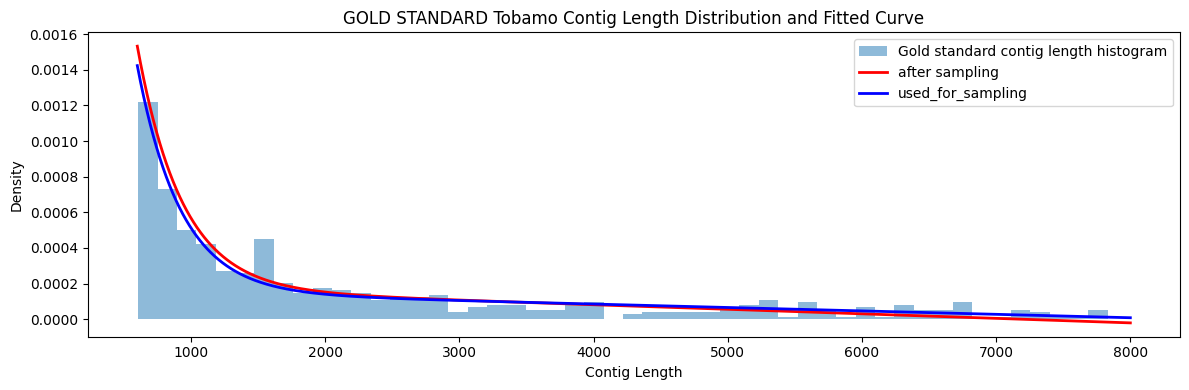

In [27]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 4))

ax.hist(df['contig_length'], bins=50, color='tab:blue', alpha=0.5, density=True, label='Gold standard contig length histogram')
ax.plot(xfine, sample_y_fitted, 'r-', label='after sampling', linewidth=2)
# If you have y_fitted, plot it as well
ax.plot(xfine, y_fitted, 'b-', label='used_for_sampling', linewidth=2)
ax.set_title('GOLD STANDARD Tobamo Contig Length Distribution and Fitted Curve')
ax.set_xlabel('Contig Length')
ax.set_ylabel('Density')
ax.legend()

plt.tight_layout()
plt.show()

Morf selection n=10

In [28]:
import glob
import os
import pandas as pd
import numpy as np

# Path to the directory
path = '/home/tobamo/analize/project-tobamo/analysis/model/results/model_selection_test_n5'

# Get all CSV files in the directory
csv_files = glob.glob(os.path.join(path, "*.csv"))

# Create an empty list to store DataFrames
dfs = []

# Read each CSV file and append to the list
for file in csv_files:
    df = pd.read_csv(file, index_col=0)
    # Optionally add filename as a column to track source
    df['source_file'] = os.path.basename(file)
    dfs.append(df)

# Concatenate all DataFrames
combined_df = pd.concat(dfs, ignore_index=True)

# Display the first few rows of the combined DataFrame
combined_df.head()

# Calculate number of iterations from the data
iterations = len(combined_df['source_file'].unique())
all_performance_metrics = combined_df.to_dict('records')

# Calculate overall model performance across all iterations
model_performances = {}
for metric in all_performance_metrics:
    model_name = metric["model"]
    if model_name not in model_performances:
        model_performances[model_name] = []
    model_performances[model_name].append(metric["accuracy"])

# Calculate average and std of accuracy for each model
avg_performances = {
    model: {
        "mean": np.mean(scores),
        "std": np.std(scores),
        "count": len(scores)
    } 
    for model, scores in model_performances.items()
}

# Find best model based on average performance
best_model = max(avg_performances.keys(), key=lambda m: avg_performances[m]["mean"])

# Count how many times each model was selected as best in individual folds
model_selection_counts = {}
for metric in all_performance_metrics:
    model_name = metric["model"]
    if model_name not in model_selection_counts:
        model_selection_counts[model_name] = 0
    model_selection_counts[model_name] += 1

# Define output directory
outdir = 'model_selection_test_n5'

# Save summary information
with open(f"../results/{outdir}/model_selection_summary.txt", "w") as f:
    f.write(f"Model Selection Summary (across {iterations} iterations)\n")
    f.write("=" * 50 + "\n\n")
    
    f.write(f"Overall Best Model: {best_model}\n")
    f.write("Average accuracy: {:.4f} ± {:.4f}\n\n".format(
        avg_performances[best_model]["mean"], 
        avg_performances[best_model]["std"]
    ))
    
    f.write("Performance by Model:\n")
    f.write("-" * 40 + "\n")
    for model, stats in avg_performances.items():
        f.write("{}: {:.4f} ± {:.4f} (selected in {}/{} folds)\n".format(
            model, stats["mean"], stats["std"],
            model_selection_counts[model],
            iterations * 5  # total number of folds across all iterations
        ))

print(f"Model selection completed across {iterations} iterations! Best model: {best_model}")

# Create a DataFrame with the summary statistics for visualization
summary_df = pd.DataFrame({
    'Model': [model for model in avg_performances.keys()],
    'Mean Accuracy': [stats['mean'] for stats in avg_performances.values()],
    'Std Deviation': [stats['std'] for stats in avg_performances.values()],
    'Selection Count': [model_selection_counts[model] for model in avg_performances.keys()]
})

# Display the summary DataFrame
summary_df.sort_values('Mean Accuracy', ascending=False)

Model selection completed across 5 iterations! Best model: RandomForest


,Model,Mean Accuracy,Std Deviation,Selection Count
0,RandomForest,0.767130,0.021024,22
1,SVM,0.752388,0.011736,3


In [29]:
combined_df

,iteration,fold,model,accuracy,auc_roc,f1_score,recall,specificity,precision,negative_predictive_value,best_params,source_file
0,1,0,RandomForest,0.738303,0.620077,0.831072,0.940342,0.299811,0.744554,0.698389,"{'max_depth': None, 'n_estimators': 100}",iter_1_performance_metrics.csv
1,1,1,SVM,0.766744,0.653300,0.849254,0.954965,0.351635,0.764614,0.779754,"{'C': 50, 'kernel': 'rbf'}",iter_1_performance_metrics.csv
2,1,2,RandomForest,0.787445,0.631882,0.869512,0.970596,0.293167,0.787497,0.786982,"{'max_depth': 50, 'n_estimators': 200}",iter_1_performance_metrics.csv
3,1,3,RandomForest,0.777824,0.638986,0.860766,0.937694,0.340278,0.795503,0.666163,"{'max_depth': 50, 'n_estimators': 200}",iter_1_performance_metrics.csv
4,1,4,RandomForest,0.772652,0.646924,0.855338,0.951112,0.342736,0.777087,0.744257,"{'max_depth': None, 'n_estimators': 150}",iter_1_performance_metrics.csv
5,0,0,SVM,0.737996,0.632587,0.827269,0.901001,0.364173,0.764692,0.615982,"{'C': 50, 'kernel': 'rbf'}",iter_0_performance_metrics.csv
6,0,1,RandomForest,0.751631,0.642321,0.838436,0.955158,0.329483,0.747134,0.779856,"{'max_depth': 50, 'n_estimators': 300}",iter_0_performance_metrics.csv
7,0,2,RandomForest,0.791389,0.647045,0.870537,0.946396,0.347695,0.805937,0.693816,"{'max_depth': 50, 'n_estimators': 300}",iter_0_performance_metrics.csv
8,0,3,RandomForest,0.785497,0.646737,0.865898,0.957703,0.335772,0.790155,0.752459,"{'max_depth': 50, 'n_estimators': 200}",iter_0_performance_metrics.csv
9,0,4,RandomForest,0.765440,0.632965,0.851735,0.952941,0.312988,0.769962,0.733777,"{'max_depth': 50, 'n_estimators': 300}",iter_0_performance_metrics.csv


In [30]:
param_performance = {}

for _, row in combined_df.iterrows():
    model_name = row['model']
    params = row['best_params']
    accuracy = row['accuracy']
    key = (model_name, str(params))
    if key not in param_performance:
        param_performance[key] = {
            'model': model_name,
            'params': params,
            'accuracies': [],
            'count': 0
        }
    param_performance[key]['accuracies'].append(accuracy)
    param_performance[key]['count'] += 1

for key in param_performance:
    accuracies = param_performance[key]['accuracies']
    param_performance[key]['mean_accuracy'] = np.mean(accuracies)
    param_performance[key]['std_accuracy'] = np.std(accuracies)

# ==== param_df is defined here ====
param_df = pd.DataFrame(list(param_performance.values()))

In [31]:
param_df

,model,params,accuracies,count,mean_accuracy,std_accuracy
0,RandomForest,"{'max_depth': None, 'n_estimators': 100}",[0.7383029341792229],1,0.738303,0.000000
1,SVM,"{'C': 50, 'kernel': 'rbf'}","[0.766743648960739, 0.7379956166567045, 0.7524...",3,0.752388,0.011736
2,RandomForest,"{'max_depth': 50, 'n_estimators': 200}","[0.787445371473977, 0.77782366301879, 0.785497...",4,0.779909,0.007319
3,RandomForest,"{'max_depth': None, 'n_estimators': 150}",[0.7726520479933803],1,0.772652,0.000000
4,RandomForest,"{'max_depth': 50, 'n_estimators': 300}","[0.7516314020170062, 0.7913894324853229, 0.765...",5,0.755190,0.022332
5,RandomForest,"{'max_depth': 40, 'n_estimators': 150}",[0.7865340474368784],1,0.786534,0.000000
6,RandomForest,"{'max_depth': 50, 'n_estimators': 150}","[0.7911259941398074, 0.7890787828261776]",2,0.790102,0.001024
7,RandomForest,"{'max_depth': None, 'n_estimators': 300}","[0.7785445420326224, 0.7392532795156408, 0.786...",4,0.763730,0.019477
8,RandomForest,"{'max_depth': 40, 'n_estimators': 200}","[0.7634768073547847, 0.7952802359882006]",2,0.779379,0.015902
9,RandomForest,"{'max_depth': None, 'n_estimators': 200}",[0.7440047961630696],1,0.744005,0.000000


In [32]:
param_df.sort_values('count', ascending=False)

,model,params,accuracies,count,mean_accuracy,std_accuracy
4,RandomForest,"{'max_depth': 50, 'n_estimators': 300}","[0.7516314020170062, 0.7913894324853229, 0.765...",5,0.755190,0.022332
2,RandomForest,"{'max_depth': 50, 'n_estimators': 200}","[0.787445371473977, 0.77782366301879, 0.785497...",4,0.779909,0.007319
7,RandomForest,"{'max_depth': None, 'n_estimators': 300}","[0.7785445420326224, 0.7392532795156408, 0.786...",4,0.763730,0.019477
1,SVM,"{'C': 50, 'kernel': 'rbf'}","[0.766743648960739, 0.7379956166567045, 0.7524...",3,0.752388,0.011736
6,RandomForest,"{'max_depth': 50, 'n_estimators': 150}","[0.7911259941398074, 0.7890787828261776]",2,0.790102,0.001024
8,RandomForest,"{'max_depth': 40, 'n_estimators': 200}","[0.7634768073547847, 0.7952802359882006]",2,0.779379,0.015902
0,RandomForest,"{'max_depth': None, 'n_estimators': 100}",[0.7383029341792229],1,0.738303,0.000000
3,RandomForest,"{'max_depth': None, 'n_estimators': 150}",[0.7726520479933803],1,0.772652,0.000000
5,RandomForest,"{'max_depth': 40, 'n_estimators': 150}",[0.7865340474368784],1,0.786534,0.000000
9,RandomForest,"{'max_depth': None, 'n_estimators': 200}",[0.7440047961630696],1,0.744005,0.000000


Decided on the least complex model out of the most commonly chosen ones

### M contig evaluation

In [8]:
comparison = pd.read_csv('/home/tobamo/analize/project-tobamo/analysis/model/results/evaluation_results/method_comparison_stats.csv', index_col=0)

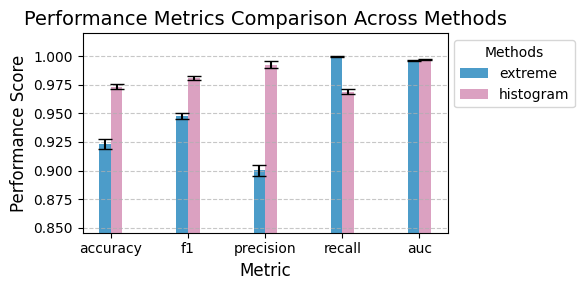

In [9]:
# Extract metrics from comparison DataFrame
metrics = ['accuracy', 'f1', 'precision', 'recall', 'auc']
methods = comparison.index

colors = ['#0072B2', '#CC79A7']
method_colors = dict(zip(methods, colors))

# Create figure
fig, ax = plt.subplots(figsize=(7, 3))

# Bar positioning
x = np.arange(len(metrics))
width = 0.15  # Wider bars since we may have more methods
bar_positions = [x + i * width - (len(methods) - 1) * width / 2 for i in range(len(methods))]

# Plot bars with error bars for each method
for i, method in enumerate(methods):
    means = [comparison.loc[method, f'{metric}_mean'] for metric in metrics]
    stds = [comparison.loc[method, f'{metric}_std'] for metric in metrics]
    
    ax.bar(bar_positions[i], means, width, yerr=stds, capsize=5, 
           label=method, alpha=0.7, color=method_colors[method])

# Formatting
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.set_xlabel('Metric', fontsize=12)
ax.set_ylabel('Performance Score', fontsize=12)

# Set y-axis limits to focus on the relevant range
y_min = max(0.5, min([comparison[f'{m}_mean'].min() - comparison[f'{m}_std'].max() for m in metrics]) - 0.05)
ax.set_ylim(y_min, 1.02)

# Add grid for easier comparison
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Title and legend
ax.set_title('Performance Metrics Comparison Across Methods', fontsize=14)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), title="Methods")

# Add CI annotations if desired
for i, method in enumerate(methods):
    for j, metric in enumerate(metrics):
        mean = comparison.loc[method, f'{metric}_mean']
        ci_low = comparison.loc[method, f'{metric}_ci95_low']
        ci_high = comparison.loc[method, f'{metric}_ci95_high']
        
        # Optional: add text annotation for 95% CI
        # ax.text(bar_positions[i], mean + 0.02, f'[{ci_low:.3f}, {ci_high:.3f}]', 
        #        ha='center', va='bottom', fontsize=8, rotation=90)

# Adjust layout for legend
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

In [20]:
comparison

,accuracy_mean,accuracy_std,accuracy_ci95_low,accuracy_ci95_high,f1_mean,f1_std,f1_ci95_low,f1_ci95_high,precision_mean,precision_std,precision_ci95_low,precision_ci95_high,recall_mean,recall_std,recall_ci95_low,recall_ci95_high,auc_mean,auc_std,auc_ci95_low,auc_ci95_high
method,,,,,,,,,,,,,,,,,,,,
extreme,0.923131,0.004042,0.921685,0.924578,0.947469,0.002618,0.946532,0.948406,0.900266,0.004689,0.898588,0.901944,0.999909,0.000252,0.999819,0.999999,0.996269,0.000425,0.996116,0.996421
histogram,0.973472,0.002252,0.972666,0.974278,0.980637,0.001633,0.980053,0.981221,0.992529,0.002937,0.991478,0.993580,0.969035,0.002220,0.968240,0.969829,0.997056,0.000469,0.996889,0.997224


In [21]:
first_row = comparison.iloc[1].tolist()
first_row

[0.9734722222222222,
 0.0022519147474928,
 0.972666384879099,
 0.9742780595653454,
 0.9806369052316478,
 0.0016327074469617,
 0.9800526483752896,
 0.981221162088006,
 0.9925285901603984,
 0.0029368146122717,
 0.9914776645483016,
 0.9935795157724948,
 0.9690346083788708,
 0.0022200691601584,
 0.9682401668328204,
 0.969829049924921,
 0.99705645505858,
 0.0004687870823507,
 0.9968887017555952,
 0.9972242083615648]

In [35]:
extreme = pd.read_csv('/home/tobamo/analize/project-tobamo/analysis/model/results/evaluation_results/extreme_predictions_results.csv')
hist = pd.read_csv('/home/tobamo/analize/project-tobamo/analysis/model/results/evaluation_results/histogram_predictions_results.csv')

df = pd.concat([extreme, hist], ignore_index=True)

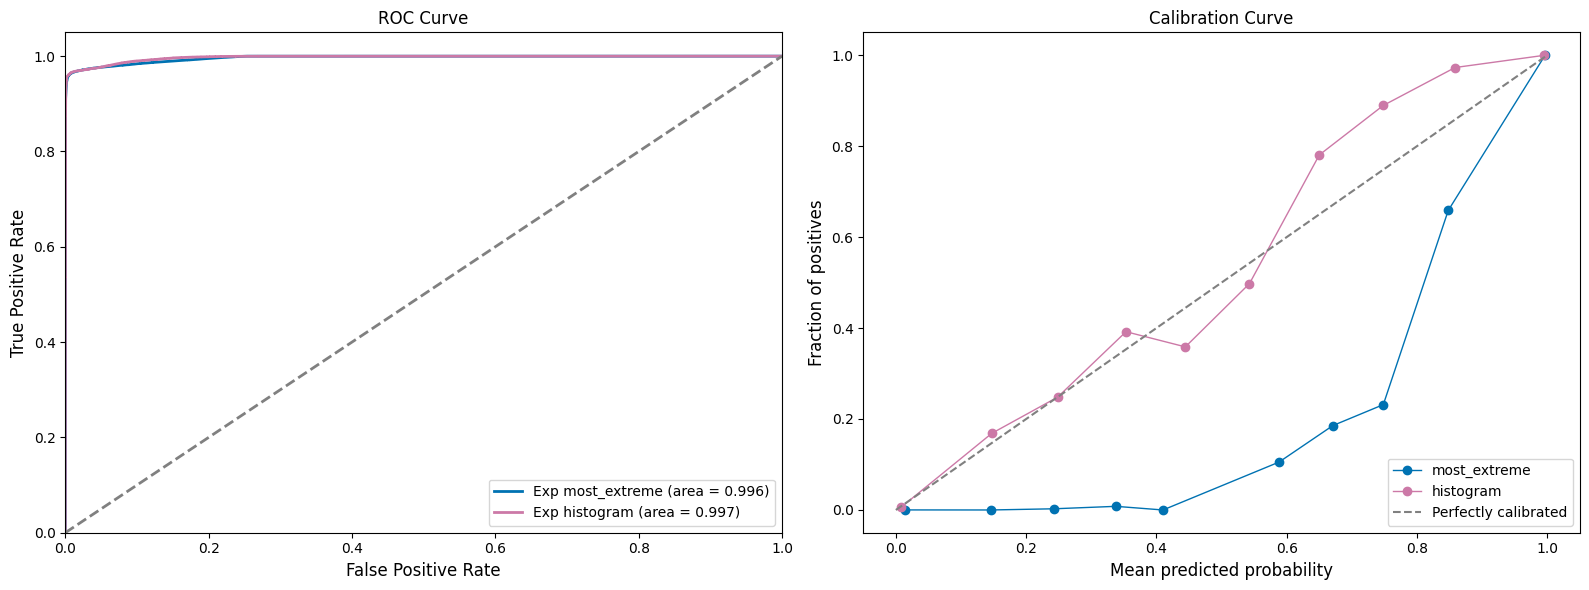

In [36]:
methods = df['mc_name'].unique()

# Define color palette for consistent colors across methods
colors = ['#0072B2', '#CC79A7']  # First two colors from tab10 (blue, orange)
method_colors = dict(zip(methods, colors))

# Aggregate results across all folds for each method
aggregated_results = []

for method in methods:
    method_data = df[df['mc_name'] == method]
    aggregated_results.append(method_data)

# Combine all aggregated results into a single DataFrame
combined_results = pd.concat(aggregated_results)

# Plot ROC curve, Precision-Recall curve, and Calibration curve for each method
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot ROC Curve for each method
for method in methods:
    method_data = combined_results[combined_results['mc_name'] == method]
    y_true = method_data['ground_truth']
    y_scores = method_data['prob_1']
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    axes[0].plot(fpr, tpr, lw=2, label=f'Exp {method} (area = {roc_auc:.3f})', 
                color=method_colors[method])

axes[0].plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])
axes[0].set_xlabel('False Positive Rate', fontsize=12)
axes[0].set_ylabel('True Positive Rate', fontsize=12)
axes[0].set_title('ROC Curve', fontsize=12)
axes[0].legend(loc="lower right")

# Plot Calibration Curve for each method
for method in methods:
    method_data = combined_results[combined_results['mc_name'] == method]
    y_true = method_data['ground_truth']
    y_scores = method_data['prob_1']
    prob_true, prob_pred = calibration_curve(y_true, y_scores, n_bins=10)
    axes[1].plot(prob_pred, prob_true, marker='o', lw=1, label=f'{method}', 
                color=method_colors[method])

axes[1].plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated', color='gray')
axes[1].set_xlabel('Mean predicted probability', fontsize=12)
axes[1].set_ylabel('Fraction of positives', fontsize=12)
axes[1].set_title('Calibration Curve', fontsize=12)
axes[1].legend(loc="lower right")

plt.tight_layout()
plt.show()

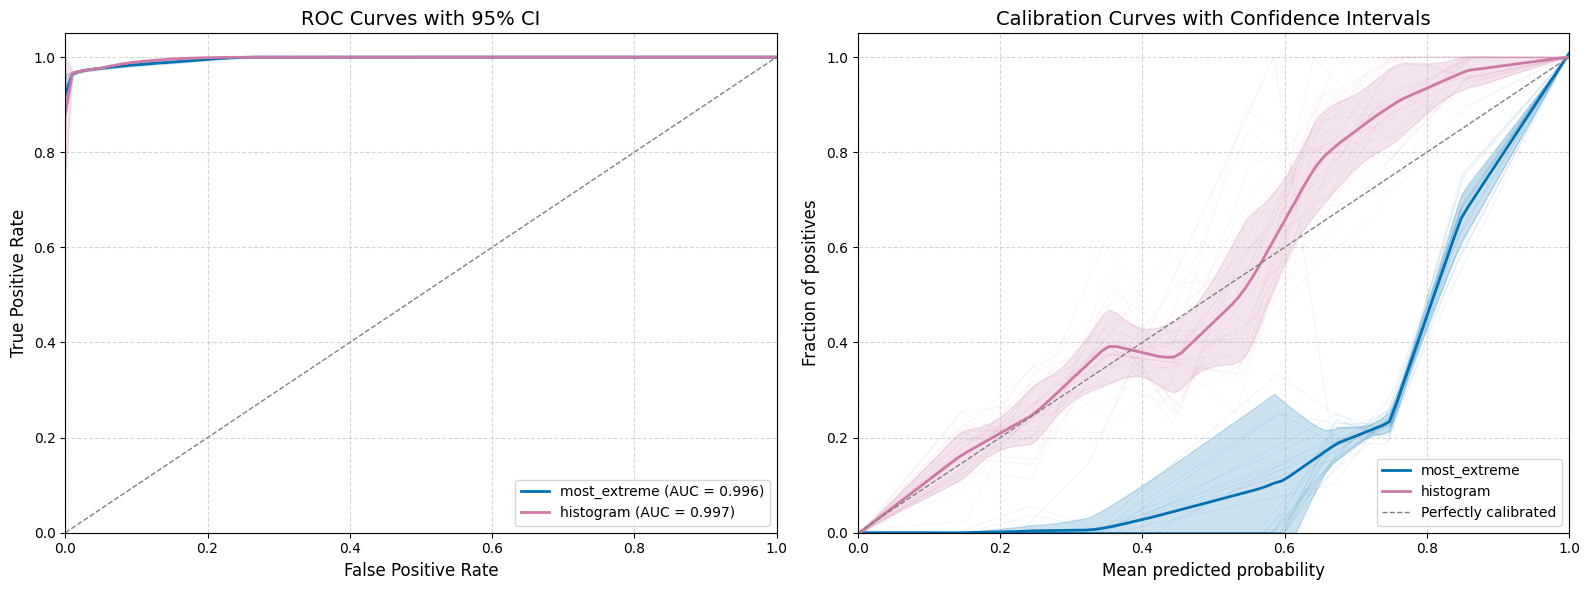

In [ ]:
# Create a figure with 2 subplots for ROC and Calibration curves
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Define color palette for consistent colors across methods
methods = df['mc_name'].unique()
# colors = ['#1f77b4', '#ff7f0e']
# colors = plt.cm.tab10(np.linspace(0, 1, len(methods)))
method_colors = dict(zip(methods, colors))

# Plot ROC Curves with confidence intervals
for i, method in enumerate(methods):
    method_data = df[df['mc_name'] == method]
    
    # Store TPR values for each FPR point to calculate confidence intervals
    tpr_values = []
    interp_fpr = np.linspace(0, 1, 100)
    
    # Calculate ROC curve for each iteration
    iterations = method_data['iteration'].unique() if 'iteration' in method_data.columns else [0]
    
    for iteration in iterations:
        iter_data = method_data[method_data['iteration'] == iteration] if 'iteration' in method_data.columns else method_data
        
        if len(iter_data) > 0:
            y_true = iter_data['ground_truth']
            y_scores = iter_data['prob_1']
            
            if len(np.unique(y_true)) > 1:  # Only compute if we have both classes
                fpr, tpr, _ = roc_curve(y_true, y_scores)
                
                # Interpolate TPR values at fixed FPR points
                interp_tpr = np.interp(interp_fpr, fpr, tpr)
                tpr_values.append(interp_tpr)
    
    # Calculate mean and std of TPR values
    if tpr_values:
        tpr_array = np.array(tpr_values)
        mean_tpr = tpr_array.mean(axis=0)
        std_tpr = tpr_array.std(axis=0)
        
        # Calculate AUC of mean curve
        mean_auc = auc(interp_fpr, mean_tpr)
        
        # Plot mean ROC curve
        axes[0].plot(interp_fpr, mean_tpr, color=method_colors[method], 
                  label=f'{method} (AUC = {mean_auc:.3f})', lw=2)
        
        # Plot confidence interval (±1 std)
        axes[0].fill_between(interp_fpr, 
                          np.maximum(0, mean_tpr - std_tpr),
                          np.minimum(1, mean_tpr + std_tpr), 
                          color=method_colors[method], alpha=0.2)

# Add reference line and formatting for ROC curve
axes[0].plot([0, 1], [0, 1], linestyle='--', color='gray', lw=1)
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])
axes[0].set_xlabel('False Positive Rate', fontsize=12)
axes[0].set_ylabel('True Positive Rate', fontsize=12)
axes[0].set_title('ROC Curves with 95% CI', fontsize=14)
axes[0].legend(loc="lower right")
axes[0].grid(True, linestyle='--', alpha=0.5)

# Plot Calibration Curves with confidence intervals
for i, method in enumerate(methods):
    method_data = df[df['mc_name'] == method]
    
    # Store calibration curves for confidence intervals
    prob_true_values = []
    prob_pred_values = []
    
    # Calculate calibration curve for each iteration
    iterations = method_data['iteration'].unique() if 'iteration' in method_data.columns else [0]
    
    for iteration in iterations:
        iter_data = method_data[method_data['iteration'] == iteration] if 'iteration' in method_data.columns else method_data
        
        if len(iter_data) > 0:
            y_true = iter_data['ground_truth']
            y_scores = iter_data['prob_1']
            
            # Only compute if we have enough data
            if len(y_true) > 10 and len(np.unique(y_true)) > 1:
                prob_true, prob_pred = calibration_curve(y_true, y_scores, n_bins=10)
                
                # Plot individual iteration curves with low opacity
                axes[1].plot(prob_pred, prob_true, color=method_colors[method], 
                         alpha=0.1, lw=0.5)
                
                # Store values for confidence interval
                prob_true_values.append(prob_true)
                prob_pred_values.append(prob_pred)
    
    # Calculate and plot mean calibration curve if we have data
    if prob_true_values:
        # Create interpolation grid
        x_interp = np.linspace(0, 1, 100)
        
        # Interpolate each curve to this grid
        interp_curves = []
        for prob_true, prob_pred in zip(prob_true_values, prob_pred_values):
            if len(prob_pred) > 1:
                # Use linear interpolation
                from scipy.interpolate import interp1d
                interp_func = interp1d(prob_pred, prob_true, 
                                     bounds_error=False, fill_value="extrapolate")
                interp_curves.append(interp_func(x_interp))
        
        # Calculate mean and std for the interpolated curves
        if interp_curves:
            interp_array = np.array(interp_curves)
            mean_curve = np.nanmean(interp_array, axis=0)
            std_curve = np.nanstd(interp_array, axis=0)
            
            # Plot mean curve with higher weight
            axes[1].plot(x_interp, mean_curve, color=method_colors[method], 
                      label=f'{method}', lw=2)
            
            # Plot confidence interval
            axes[1].fill_between(x_interp, 
                              np.maximum(0, mean_curve - std_curve),
                              np.minimum(1, mean_curve + std_curve), 
                              color=method_colors[method], alpha=0.2)

# Add reference line and formatting for Calibration curve
axes[1].plot([0, 1], [0, 1], linestyle='--', color='gray', lw=1, label='Perfectly calibrated')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('Mean predicted probability', fontsize=12)
axes[1].set_ylabel('Fraction of positives', fontsize=12)
axes[1].set_title('Calibration Curves with Confidence Intervals', fontsize=14)
axes[1].legend(loc="lower right")
axes[1].grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

### Error Rate viz

In [38]:
# import histogram prediction results
df = pd.read_csv('/home/tobamo/analize/project-tobamo/analysis/model/results/evaluation_results/histogram_predictions_results.csv', index_col=0)

# add missing info
df['predicted_class'] = np.where(df['prob_1'] < 0.5, 0, 1)
df['correct_prediction'] = df['ground_truth'] == df['predicted_class']
df['contig_length'] = df["contig_name"].str.extract(r"len-(\d+)").astype(int)
df['contig_start'] = df['contig_name'].str.extract(r'_start-(\d+)').astype(int)
df['contig_end'] = df['contig_start'] + df['contig_length']

# add reference length
refs_lens = {
    re.match(r"^(.*\.\d)_", rec.id).group(1): len(rec.seq)
    for rec in SeqIO.parse('/home/tobamo/analize/model-tobamo/notebooks/MODEL/data/reference_nukleotidne.fasta', 'fasta')
}
df['accession'] = df['contig_name'].str.extract(r"^(.*\.\d)_")
df['ref_len'] = df['accession'].map(refs_lens)

# keep only tobamo
tobamo = df[df['ground_truth'] == 1]

normalize lengths

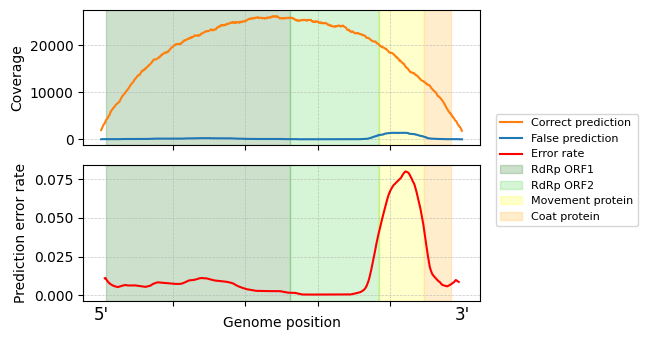

In [39]:
# Normalize contig_start and contig_end by ref_len to make lengths relative
tobamo = tobamo.copy()
tobamo['relative_start'] = tobamo['contig_start'] / tobamo['ref_len']
tobamo['relative_end'] = tobamo['contig_end'] / tobamo['ref_len']

# Define the genome length as 1 (since we're working with relative lengths)
genome_length = 1.0

# Initialize a dictionary to store coverage arrays for each correct_prediction group
coverage_by_prediction = {}

# Group the data by 'correct_prediction' and calculate coverage for each group
for prediction, group in tobamo.groupby('correct_prediction'):
    # Initialize a coverage array with zeros (use 1000 bins for relative positions)
    bins = 1000
    coverage = np.zeros(bins)
    
    # Increment the coverage array for each contig in the group
    for start, end in zip(group['relative_start'], group['relative_end']):
        start_bin = int(start * bins)
        end_bin = int(end * bins)
        coverage[start_bin:end_bin] += 1
    
    # Store the coverage array in the dictionary
    coverage_by_prediction[prediction] = coverage

# Define the genome length as 1 (since we're working with relative lengths)
genome_length = 1.0

# Initialize dictionaries to store coverage arrays for correct and incorrect predictions
bins = 1000
coverage_correct = np.zeros(bins)
coverage_incorrect = np.zeros(bins)

# Group the data by 'correct_prediction' and calculate coverage for each group
for prediction, group in tobamo.groupby('correct_prediction'):
    # Increment the coverage array for each contig in the group
    for start, end in zip(group['relative_start'], group['relative_end']):
        start_bin = int(start * bins)
        end_bin = int(end * bins)
        if prediction:  # True for correct predictions
            coverage_correct[start_bin:end_bin] += 1
        else:  # False for incorrect predictions
            coverage_incorrect[start_bin:end_bin] += 1

# Calculate the error rate (incorrect / total coverage)
total_coverage = coverage_correct + coverage_incorrect
error_rate = np.divide(coverage_incorrect, total_coverage, out=np.zeros_like(coverage_incorrect), where=total_coverage != 0)

# Create a DataFrame for plotting
coverage_df = pd.DataFrame({
    'Relative Position': np.linspace(0, genome_length, bins),
    'Error Rate': error_rate
})

# set examplery regions of interest
rdrp_orf1_start = 77/6393
rdrp_orf1_end = 3348/6393

rdrp_orf2_start = 3350/6393
rdrp_orf2_end = 4924/6393

mp_start = 4911/6393
mp_end = 5711/6393

cp_start = 5714/6393
cp_end = 6193/6393

# Create a DataFrame for plotting without smoothing
unsmoothed_coverage_df = pd.DataFrame({
    'Relative Position': np.linspace(0, genome_length, bins),
    **{f"Coverage_{prediction}": coverage for prediction, coverage in coverage_by_prediction.items()}
})

# Add a smoothed error rate using a rolling average for the second graph
coverage_df['Smoothed Error Rate'] = coverage_df['Error Rate'].rolling(window=20, center=True).mean()

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5, 3.5), sharex=True)

# Plot the unsmoothed coverage for each correct_prediction group (first subplot)
for prediction in coverage_by_prediction.keys():
    label = "Correct prediction" if prediction else "False prediction"
    sns.lineplot(
        data=unsmoothed_coverage_df,
        x='Relative Position',
        y=f"Coverage_{prediction}",
        ax=ax1,
        label=label
    )

# Add labels and highlight regions of interest for the first subplot
ax1.set_ylabel('Coverage', fontsize=10)
ax1.axvspan(mp_start, mp_end, color='yellow', alpha=0.2, label='Movement protein')
ax1.axvspan(cp_start, cp_end, color='orange', alpha=0.2, label='Coat protein')
ax1.axvspan(rdrp_orf1_start, rdrp_orf1_end, color='darkgreen', alpha=0.2, label='RdRp ORF1')
ax1.axvspan(rdrp_orf2_start, rdrp_orf2_end, color='limegreen', alpha=0.2, label='RdRp ORF2')
ax1.grid(visible=True, which='major', linestyle='--', linewidth=0.5, alpha=0.7)

# Plot the smoothed error rate (second subplot)
sns.lineplot(data=coverage_df, x='Relative Position', y='Smoothed Error Rate', ax=ax2, color='red', label='Error rate')

# Add labels and highlight regions of interest for the second subplot
ax2.set_xlabel('Genome position', fontsize=10)
ax2.set_ylabel('Prediction error rate', fontsize=10)
ax2.axvspan(mp_start, mp_end, color='yellow', alpha=0.2, label='Movement protein')
ax2.axvspan(cp_start, cp_end, color='orange', alpha=0.2, label='Coat protein')
ax2.axvspan(rdrp_orf1_start, rdrp_orf1_end, color='darkgreen', alpha=0.2, label='RdRp ORF1')
ax2.axvspan(rdrp_orf2_start, rdrp_orf2_end, color='limegreen', alpha=0.2, label='RdRp ORF2')
ax2.grid(visible=True, which='major', linestyle='--', linewidth=0.5, alpha=0.7)

# Add custom x-axis labels (5' and 3') for both subplots
ax2.text(0.0, ax2.get_ylim()[0] - (ax2.get_ylim()[1] * 0.15), "5'", fontsize=12, ha='center', color='black')
ax2.text(1.0, ax2.get_ylim()[0] - (ax2.get_ylim()[1] * 0.15), "3'", fontsize=12, ha='center', color='black')

# Set x-axis ticks at 0.2, 0.4, 0.6, and 0.8 for gridlines
ax2.set_xticks([0.2, 0.4, 0.6, 0.8])
ax2.set_xticklabels([])

# Remove individual legends
ax1.legend_.remove()
ax2.legend_.remove()

# Create a combined legend
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
handles, labels = [], []

# Combine handles and labels, avoiding duplicates
for h, l in zip(handles1 + handles2, labels1 + labels2):
    if l not in labels:
        handles.append(h)
        labels.append(l)

# Define the desired order of legend elements
desired_order = [
    "Correct prediction",
    "False prediction",
    "Error rate",
    "RdRp ORF1",
    "RdRp ORF2",
    "Movement protein",
    "Coat protein"
]

# Reorder handles and labels based on the desired order
ordered_handles_labels = sorted(zip(handles, labels), key=lambda x: desired_order.index(x[1]))
ordered_handles, ordered_labels = zip(*ordered_handles_labels)

# Combine handles and labels, avoiding duplicates
for h, l in zip(handles1 + handles2, labels1 + labels2):
    if l not in labels:
        handles.append(h)
        labels.append(l)

fig.legend(ordered_handles, ordered_labels, loc='center left', fontsize=8, bbox_to_anchor=(0.99, 0.5))

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plot
plt.show()

#### False tobamo predictions

In [40]:
# import histogram prediction results
df = pd.read_csv('/home/tobamo/analize/project-tobamo/analysis/model/results/evaluation_results/histogram_predictions_results.csv', index_col=0)

# add missing info
df['contig_length'] = df["contig_name"].str.extract(r"len-(\d+)").astype(int)
df['predicted_class'] = np.where(df['prob_1'] < 0.5, 0, 1)
df['correct_prediction'] = df['ground_truth'] == df['predicted_class']
false = df[df['correct_prediction'] == False]

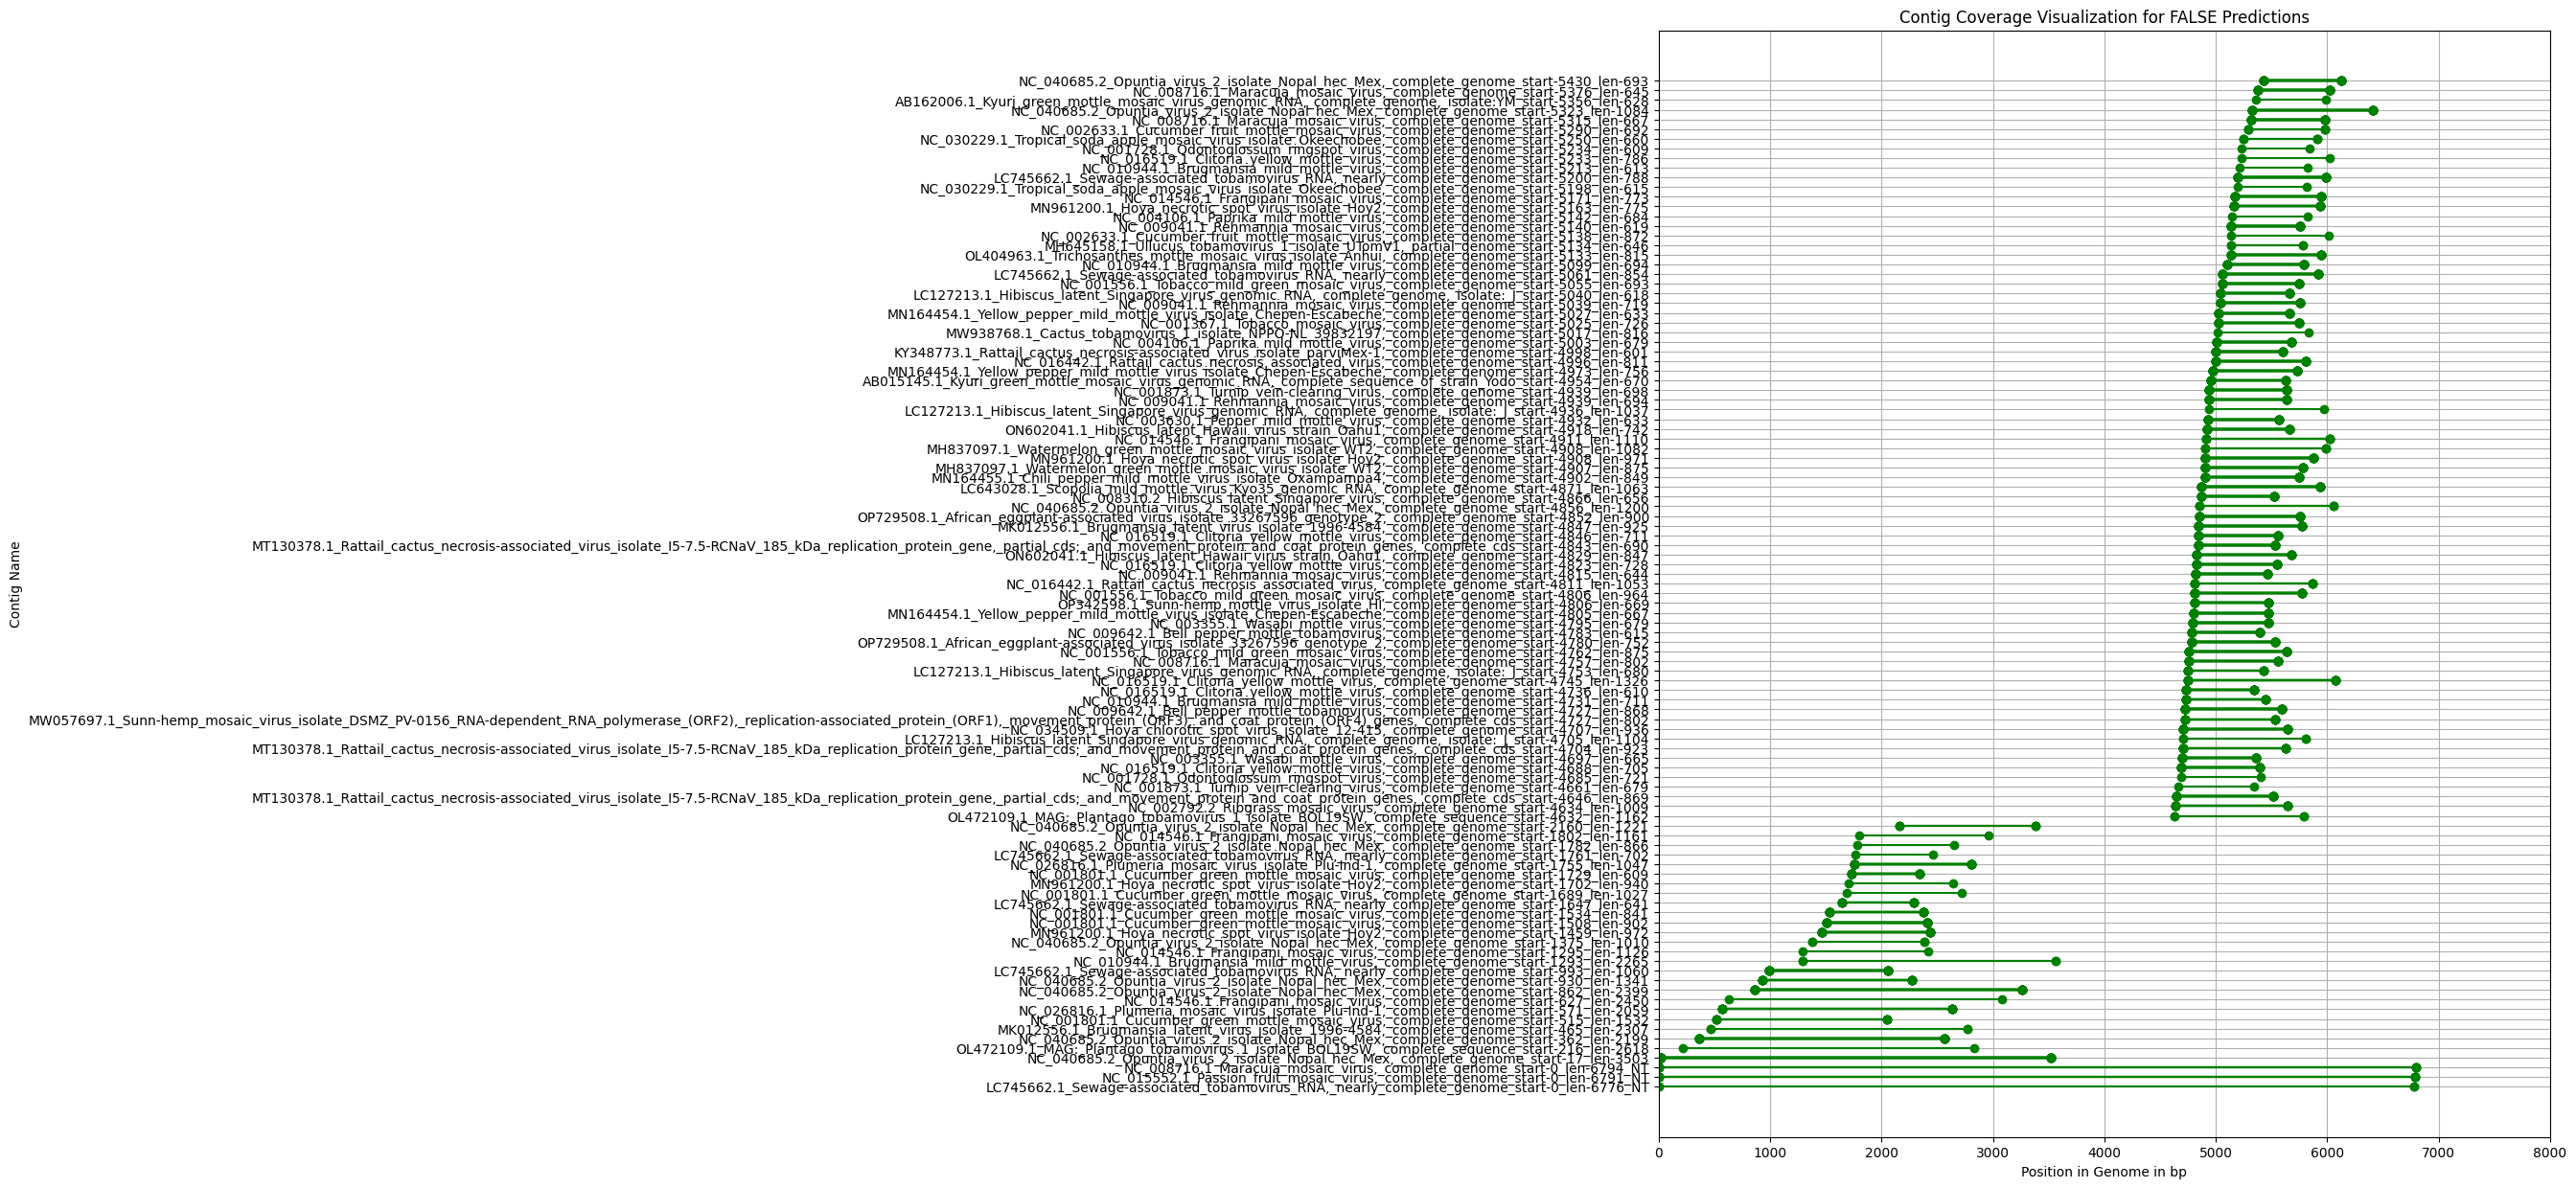

In [41]:
import matplotlib.lines as mlines
# plot tobamo
false = false[false['ground_truth'] == 1]
false = false.copy()

false['contig_start'] = false['contig_name'].str.extract(r'_start-(\d+)').astype(int)
false['contig_length'] = false['contig_length'].astype(int)
false['contig_end'] = false['contig_start'] + false['contig_length']
false.sort_values(['contig_start', 'contig_length'], inplace=True)

# Create the plot
plt.figure(figsize=(12, 15))
colors = {True: 'green', False: 'orange'}  # Define colors for ground_truth

for _, row in false.iterrows():
    plt.plot([row['contig_start'], row['contig_end']], [row['contig_name'], row['contig_name']], 
            marker='o', color=colors[row['ground_truth']])
    
# Create custom legend handles
true_handle = mlines.Line2D([], [], color='green', marker='o', linestyle='-', markersize=5, label='tobamo')

plt.xlim(0, 8000)
plt.xlabel('Position in Genome in bp')
plt.ylabel('Contig Name')
plt.title(f'Contig Coverage Visualization for FALSE Predictions')
plt.grid(True)
plt.show()

### Feature importance

In [43]:
fi = pd.read_csv('/home/tobamo/analize/project-tobamo/analysis/model/results/final_model/top_40_features.csv')

/tmp/ipykernel_3526556/3881390312.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=fi, palette='viridis')


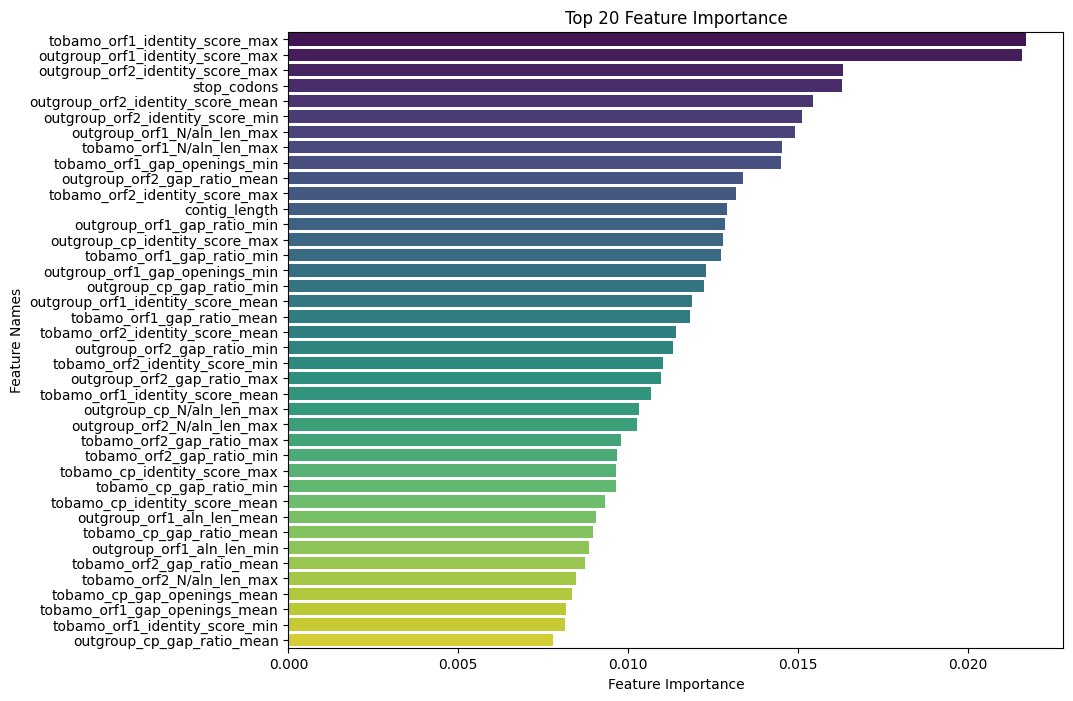

In [44]:
# Plot the top 20 feature importances
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=fi, palette='viridis')
plt.title('Top 20 Feature Importance')
plt.xlabel('Feature Importance')
plt.ylabel('Feature Names')
plt.show()

### Explained variance by number of features

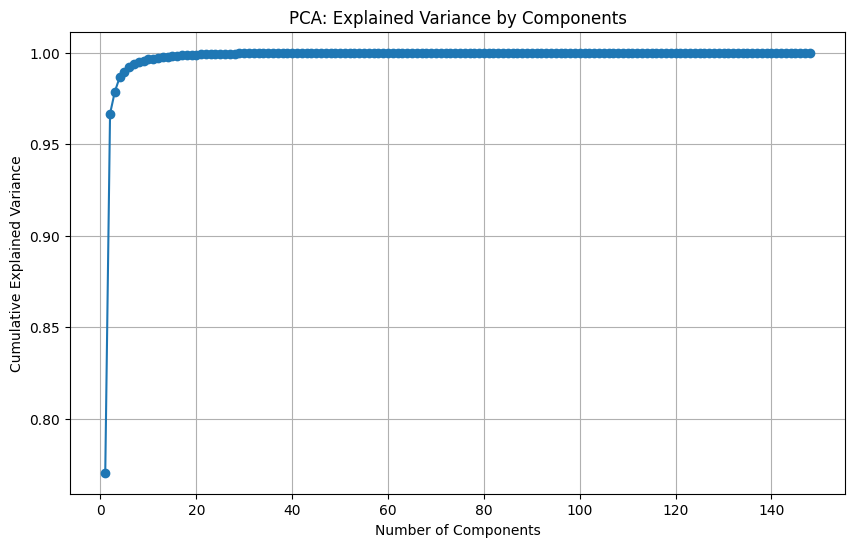

In [45]:
# 4. Dimensionality reduction with PCA
from sklearn.decomposition import PCA

# Load the training input data
training_data = pd.read_csv('../results/training/training_input.csv', index_col=0)

# Apply PCA
pca = PCA()
pca_result = pca.fit_transform(training_data.select_dtypes(include=[float, int]))

# Plot variance explained by components
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), 
         pca.explained_variance_ratio_.cumsum(), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA: Explained Variance by Components')
plt.grid(True)
plt.show()

### SNAKEMAKE RESULTS

In [5]:
gt = pd.read_excel('/home/tobamo/analize/project-tobamo/analysis/data/domain_sci_input/ground_truth_20250630.xlsx')
gt.columns = gt.columns.str.strip()
pr = pd.read_csv('/home/tobamo/analize/project-tobamo/analysis/model/results/snakemake/predictions/contig_predictions.csv')
merge = pd.merge(gt, pr, on='contig_name', how='inner')

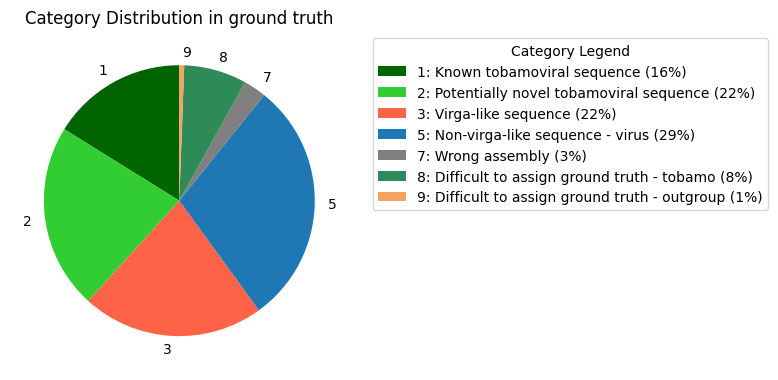

In [4]:
import matplotlib.pyplot as plt

# Prepare value counts (including NaN as a category)
category_counts = gt['category'].value_counts(dropna=False).sort_index()
total = category_counts.sum()

# Define the category palette
category_palette = {
    1: "#006400",   # dark green
    2: "#32CD32",   # lime green
    8: "#2E8B57",   # sea green
    3: "#FF6347",   # tomato
    4: "#FFA500",   # orange
    9: "#F4A460",   # sandy brown
    5: "#1f77b4",   # blue
    6: "#6baed6",   # light blue
    7: "#7f7f7f",   # grey
}

# Define the mapping dictionary
category_map = {
    1: "Known tobamoviral sequence",
    2: "Potentially novel tobamoviral sequence",
    3: "Virga-like sequence",
    4: "Known virga-outgroup",
    5: "Non-virga-like sequence - virus",
    6: "Non-virga-like sequence - other",
    7: "Wrong assembly",
    8: "Difficult to assign ground truth - tobamo",
    9: "Difficult to assign ground truth - outgroup",
    float('nan'): "NaN (missing category)"
}

# Create colors list based on the category palette
colors = []
labels = []
for cat in category_counts.index:
    if pd.isna(cat):
        colors.append('#cccccc')  # Grey for NaN
        labels.append("NaN")
    else:
        colors.append(category_palette.get(int(cat), '#cccccc'))
        labels.append(str(int(cat)))

# Pie plot with only category numbers as labels (no percentages)
plt.figure(figsize=(8, 8))
wedges, texts = plt.pie(
    category_counts,
    labels=labels,
    colors=colors,
    startangle=90,
    labeldistance=1.1
)

# Build legend labels with percentages (rounded to integer)
legend_labels = []
for cat in category_counts.index:
    count = category_counts[cat]
    percent = round(100 * count / total)
    if pd.isna(cat):
        legend_labels.append(f"NaN: missing category ({percent}%)")
    else:
        legend_labels.append(f"{int(cat)}: {category_map.get(int(cat), 'Unknown')} ({percent}%)")

plt.legend(wedges, legend_labels, title="Category Legend", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Category Distribution in ground truth')
plt.tight_layout()
plt.show()

In [7]:
gt.ground_truth.value_counts()

ground_truth
0    281
1    239
Name: count, dtype: int64

In [6]:
gt.category.value_counts()

category
5    152
2    115
3    113
1     84
8     39
7     14
9      3
Name: count, dtype: int64

confusion matrix

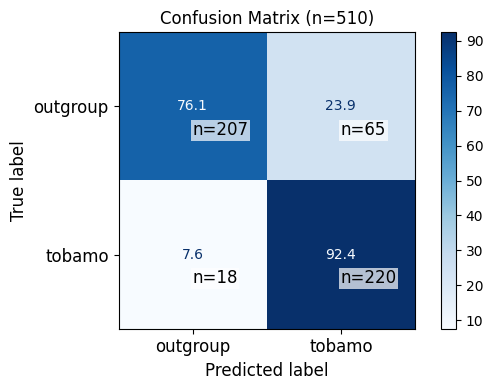

In [3]:
# Generate the confusion matrix
cm = confusion_matrix(merge['ground_truth'], merge['predicted_class'])

# Normalize the confusion matrix to percentages
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Create the figure and axes
fig, ax = plt.subplots(figsize=(6, 4))

# Display the confusion matrix with percentages - use custom labels
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm_percentage,
    display_labels=['outgroup', 'tobamo']  # Custom labels instead of 0,1
)
disp.plot(cmap=plt.cm.Blues, values_format=".1f", ax=ax)

# Set fontsize for tick labels and axis labels
ax.tick_params(labelsize=12)
ax.set_xlabel('Predicted label', fontsize=12)
ax.set_ylabel('True label', fontsize=12)

# Add text annotations for the actual counts
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        # Position the raw count in the top-left corner of each cell
        ax.text(j, i+0.1, f"n={cm[i, j]}", 
                va='top', ha='left',
                fontsize=12, 
                color='black', 
                bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=1))

# Set title and adjust layout
plt.title(f"Confusion Matrix (n={len(merge)})")
plt.tight_layout()
plt.show()

AUC ROC

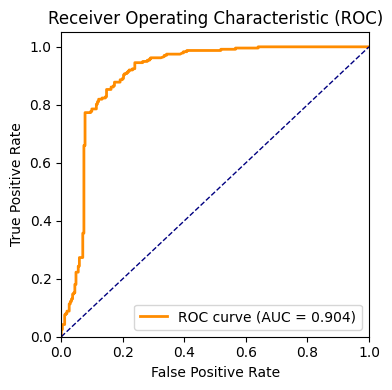

In [5]:
# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(merge['ground_truth'], merge['prob_1'])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(4, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

BOXPLOT, STRIPPLOT and VIOLINPLOT

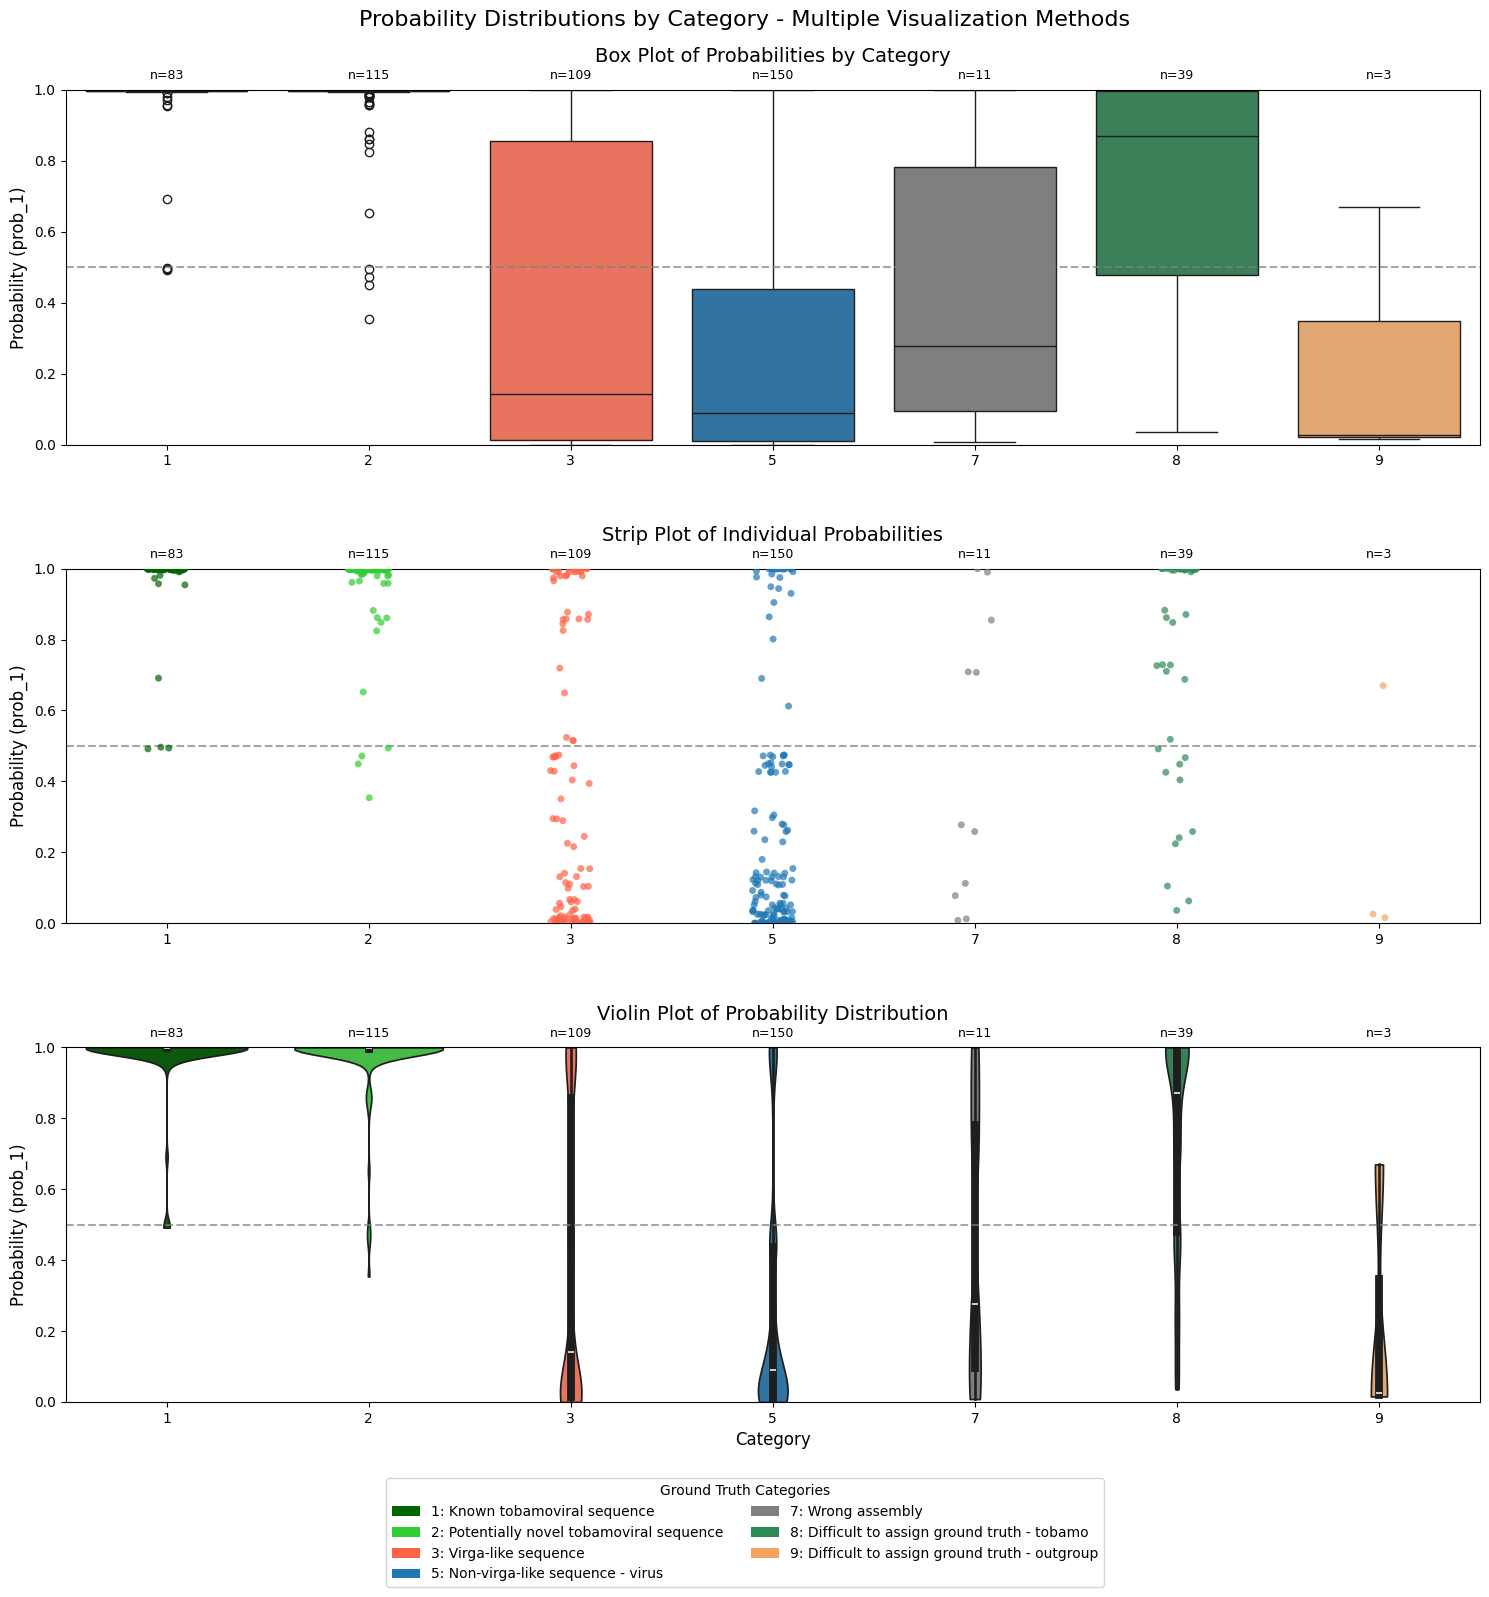

In [49]:
# Create a figure with three subplots (box, strip, and violin)
fig, axes = plt.subplots(3, 1, figsize=(15, 16), sharex=True)

df_filtered = merge.copy()
df_filtered['category'] = df_filtered['category'].astype(str)
df_filtered['prob_1'] = df_filtered['prob_1'].astype(float)
sorted_labels = sorted(df_filtered['category'].dropna().unique())

# Define the category palette
category_palette = {
    '1': "#006400",   # dark green
    '2': "#32CD32",   # lime green
    '8': "#2E8B57",   # sea green
    '3': "#FF6347",   # tomato
    '4': "#FFA500",   # orange
    '9': "#F4A460",   # sandy brown
    '5': "#1f77b4",   # blue
    '6': "#6baed6",   # light blue
    '7': "#7f7f7f",   # grey
}

# Define category descriptions
category_map = {
    '1': "Known tobamoviral sequence",
    '2': "Potentially novel tobamoviral sequence",
    '3': "Virga-like sequence",
    '4': "Known virga-outgroup",
    '5': "Non-virga-like sequence - virus",
    '6': "Non-virga-like sequence - other",
    '7': "Wrong assembly",
    '8': "Difficult to assign ground truth - tobamo",
    '9': "Difficult to assign ground truth - outgroup"
}

# 1. Box plot with proper hue parameter
sns.boxplot(data=df_filtered, x='category', y='prob_1', order=sorted_labels, 
           hue='category', palette=category_palette, legend=False, ax=axes[0])
axes[0].set_title('Box Plot of Probabilities by Category', fontsize=14, pad=20)
axes[0].set_ylabel('Probability (prob_1)', fontsize=12)
axes[0].set_ylim(0, 1)  # Enforce proper probability range
axes[0].set_xlabel('')  # Remove x-axis label as it will be shown only on the bottom plot

# Add reference line at 0.5 (classification threshold)
axes[0].axhline(y=0.5, color='gray', linestyle='--', alpha=0.7)

# 2. Strip plot with proper hue parameter
sns.stripplot(data=df_filtered, x='category', y='prob_1', order=sorted_labels, 
              jitter=True, alpha=0.7, hue='category', palette=category_palette,
              legend=False, ax=axes[1])
axes[1].set_title('Strip Plot of Individual Probabilities', fontsize=14, pad=20)
axes[1].set_ylabel('Probability (prob_1)', fontsize=12)
axes[1].set_ylim(0, 1)  # Enforce proper probability range
axes[1].set_xlabel('')  # Remove x-axis label as it will be shown only on the bottom plot
axes[1].axhline(y=0.5, color='gray', linestyle='--', alpha=0.7)  # Add threshold line

# 3. Violin plot with proper hue parameter
sns.violinplot(data=df_filtered, x='category', y='prob_1', order=sorted_labels, 
              cut=0, hue='category', palette=category_palette, common_norm=True, bw_adjust=0.5, legend=False, ax=axes[2])
axes[2].set_title('Violin Plot of Probability Distribution', fontsize=14, pad=20)
axes[2].set_xlabel('Category', fontsize=12)
axes[2].set_ylabel('Probability (prob_1)', fontsize=12)
axes[2].set_ylim(0, 1)  # Enforce proper probability range
axes[2].axhline(y=0.5, color='gray', linestyle='--', alpha=0.7)  # Add threshold line

# Set x-axis ticks without rotation for all subplots
for ax in axes:
    # Don't rotate the labels
    ax.tick_params(axis='x', rotation=0)
    
    # Make x-tick labels visible on all subplots (override sharex behavior)
    ax.xaxis.set_tick_params(labelbottom=True)
    
    # Add padding between tick labels
    plt.setp(ax.get_xticklabels(), ha='center')
    
    # Add counts above each category
    for i, category in enumerate(sorted_labels):
        count = len(df_filtered[df_filtered['category'] == category])
        ax.text(i, 1.03, f'n={count}', ha='center', fontsize=9)

# Create legend patches with category colors and descriptions
legend_handles = []
for cat in sorted(category_palette.keys()):
    if cat in df_filtered['category'].unique():  # Only include categories present in the data
        patch = plt.Rectangle((0,0), 1, 1, fc=category_palette[cat])
        legend_handles.append((patch, f"{cat}: {category_map[cat]}"))

patches, labels = zip(*legend_handles)

# Add a legend for the figure with the category descriptions
fig.legend(
    patches, labels,
    loc='lower center',
    bbox_to_anchor=(0.5, 0),
    title="Ground Truth Categories",
    fontsize=10,
    ncol=2
)

# Add a main title for the entire figure
fig.suptitle('Probability Distributions by Category - Multiple Visualization Methods', 
             fontsize=16, y=0.99)

# Adjust layout with increased spacing between subplots to accommodate labels
plt.tight_layout()
plt.subplots_adjust(bottom=0.12, top=0.94, hspace=0.35)  # Increased hspace for labels
plt.show()

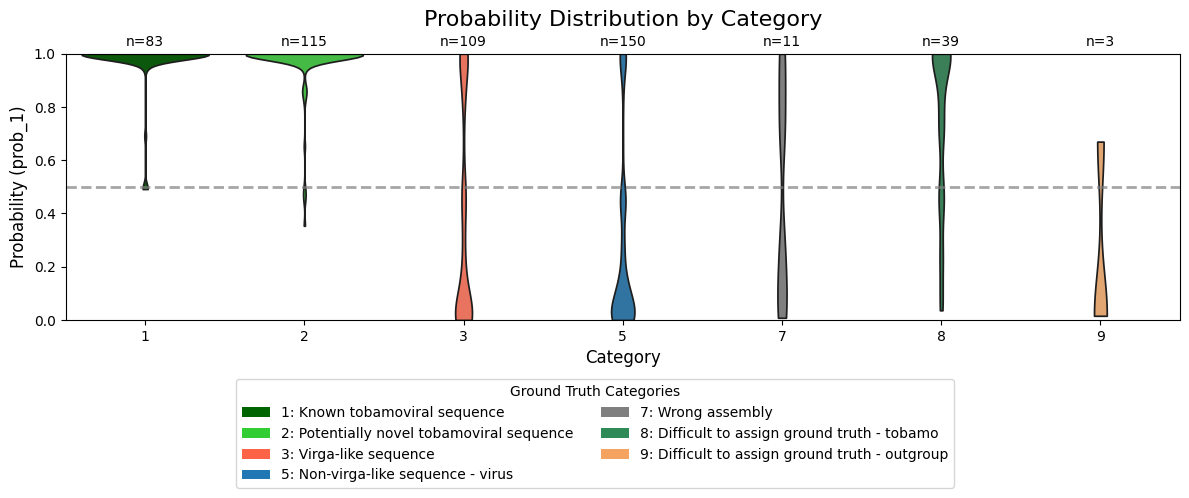

In [19]:
# Create a single figure with violin plot only
fig, ax = plt.subplots(1, 1, figsize=(12, 5))

df_filtered = merge.copy()
df_filtered['category'] = df_filtered['category'].astype(str)
df_filtered['prob_1'] = df_filtered['prob_1'].astype(float)
sorted_labels = sorted(df_filtered['category'].dropna().unique())

# Define the category palette
category_palette = {
    '1': "#006400",   # dark green
    '2': "#32CD32",   # lime green
    '8': "#2E8B57",   # sea green
    '3': "#FF6347",   # tomato
    '4': "#FFA500",   # orange
    '9': "#F4A460",   # sandy brown
    '5': "#1f77b4",   # blue
    '6': "#6baed6",   # light blue
    '7': "#7f7f7f",   # grey
}

# Define category descriptions
category_map = {
    '1': "Known tobamoviral sequence",
    '2': "Potentially novel tobamoviral sequence",
    '3': "Virga-like sequence",
    '4': "Known virga-outgroup",
    '5': "Non-virga-like sequence - virus",
    '6': "Non-virga-like sequence - other",
    '7': "Wrong assembly",
    '8': "Difficult to assign ground truth - tobamo",
    '9': "Difficult to assign ground truth - outgroup"
}

# Violin plot
sns.violinplot(data=df_filtered, x='category', y='prob_1', order=sorted_labels, 
              cut=0, hue='category', palette=category_palette, common_norm=True, 
              bw_adjust=0.5, legend=False, inner=None, ax=ax)

# Formatting
ax.set_title('Probability Distribution by Category', fontsize=16, pad=20)
ax.set_xlabel('Category', fontsize=12)
ax.set_ylabel('Probability (prob_1)', fontsize=12)
ax.set_ylim(0, 1)

# Add reference line at 0.5 (classification threshold)
ax.axhline(y=0.5, color='gray', linestyle='--', alpha=0.7, linewidth=2)

# Set x-axis ticks without rotation
ax.tick_params(axis='x', rotation=0)

# Add counts above each category
for i, category in enumerate(sorted_labels):
    count = len(df_filtered[df_filtered['category'] == category])
    ax.text(i, 1.03, f'n={count}', ha='center', fontsize=10)

# Create legend patches with category colors and descriptions
legend_handles = []
for cat in sorted(category_palette.keys()):
    if cat in df_filtered['category'].unique():
        patch = plt.Rectangle((0,0), 1, 1, fc=category_palette[cat])
        legend_handles.append((patch, f"{cat}: {category_map[cat]}"))

patches, labels = zip(*legend_handles)

# Add legend
fig.legend(
    patches, labels,
    loc='lower center',
    bbox_to_anchor=(0.5, 0),
    title="Ground Truth Categories",
    fontsize=10,
    ncol=2
)

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(bottom=0.35)
plt.show()

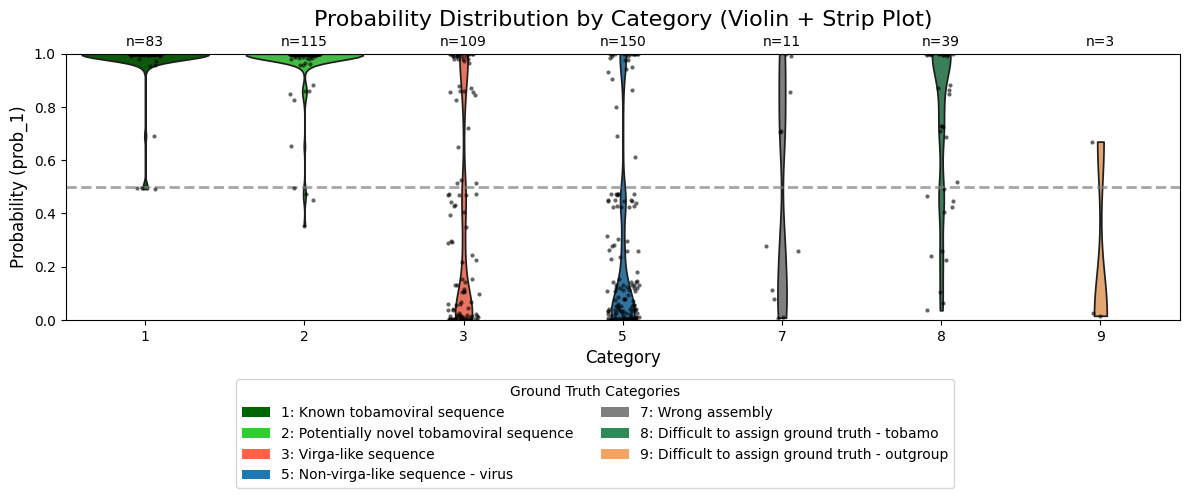

In [26]:
# Create a single figure with violin plot and strip plot overlay
fig, ax = plt.subplots(1, 1, figsize=(12, 5))

df_filtered = merge.copy()
df_filtered['category'] = df_filtered['category'].astype(str)
df_filtered['prob_1'] = df_filtered['prob_1'].astype(float)
sorted_labels = sorted(df_filtered['category'].dropna().unique())

# Define the category palette
category_palette = {
    '1': "#006400",   # dark green
    '2': "#32CD32",   # lime green
    '8': "#2E8B57",   # sea green
    '3': "#FF6347",   # tomato
    '4': "#FFA500",   # orange
    '9': "#F4A460",   # sandy brown
    '5': "#1f77b4",   # blue
    '6': "#6baed6",   # light blue
    '7': "#7f7f7f",   # grey
}

# Define category descriptions
category_map = {
    '1': "Known tobamoviral sequence",
    '2': "Potentially novel tobamoviral sequence",
    '3': "Virga-like sequence",
    '4': "Known virga-outgroup",
    '5': "Non-virga-like sequence - virus",
    '6': "Non-virga-like sequence - other",
    '7': "Wrong assembly",
    '8': "Difficult to assign ground truth - tobamo",
    '9': "Difficult to assign ground truth - outgroup"
}

# Violin plot
sns.violinplot(data=df_filtered, x='category', y='prob_1', order=sorted_labels, 
              cut=0, hue='category', palette=category_palette, common_norm=True, 
              bw_adjust=0.5, legend=False, inner=None, ax=ax)

# Strip plot overlay
sns.stripplot(data=df_filtered, x='category', y='prob_1', order=sorted_labels,
              size=3, alpha=0.6, jitter=True, color='black', ax=ax)

# Formatting
ax.set_title('Probability Distribution by Category (Violin + Strip Plot)', fontsize=16, pad=20)
ax.set_xlabel('Category', fontsize=12)
ax.set_ylabel('Probability (prob_1)', fontsize=12)
ax.set_ylim(0, 1)

# Add reference line at 0.5 (classification threshold)
ax.axhline(y=0.5, color='gray', linestyle='--', alpha=0.7, linewidth=2)

# Set x-axis ticks without rotation
ax.tick_params(axis='x', rotation=0)

# Add counts above each category
for i, category in enumerate(sorted_labels):
    count = len(df_filtered[df_filtered['category'] == category])
    ax.text(i, 1.03, f'n={count}', ha='center', fontsize=10)

# Create legend patches with category colors and descriptions
legend_handles = []
for cat in sorted(category_palette.keys()):
    if cat in df_filtered['category'].unique():
        patch = plt.Rectangle((0,0), 1, 1, fc=category_palette[cat])
        legend_handles.append((patch, f"{cat}: {category_map[cat]}"))

patches, labels = zip(*legend_handles)

# Add legend
fig.legend(
    patches, labels,
    loc='lower center',
    bbox_to_anchor=(0.5, 0),
    title="Ground Truth Categories",
    fontsize=10,
    ncol=2
)

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(bottom=0.35)
plt.show()

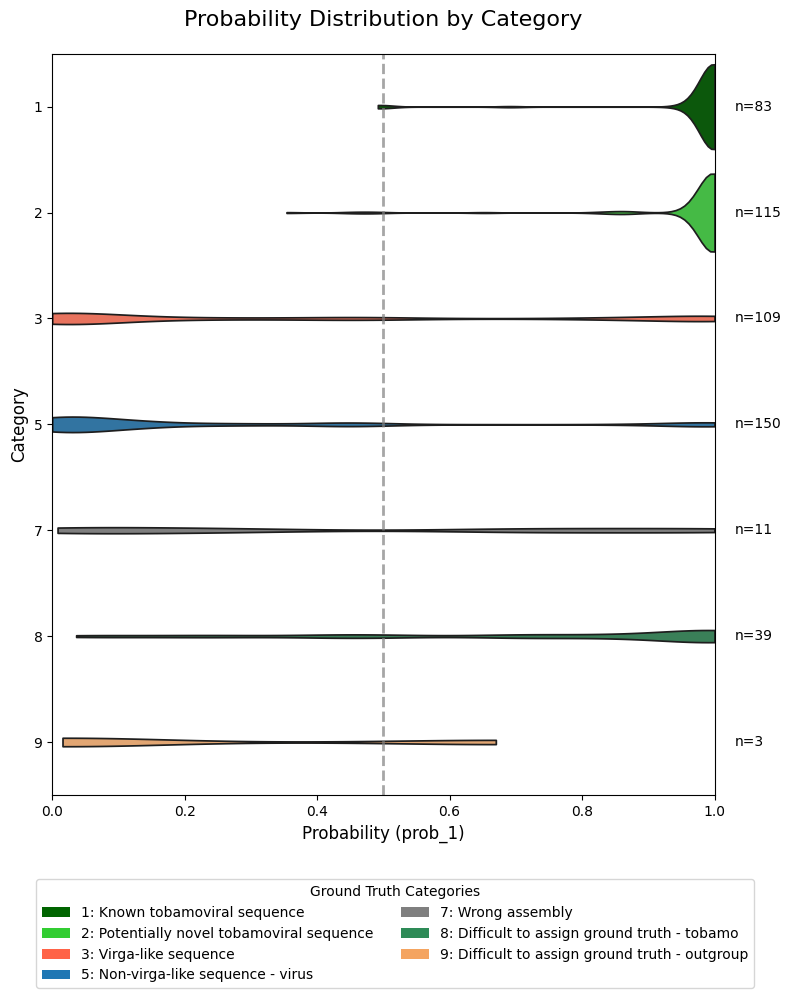

In [25]:
# Create a single figure with violin plot only
fig, ax = plt.subplots(1, 1, figsize=(8, 10))

df_filtered = merge.copy()
df_filtered['category'] = df_filtered['category'].astype(str)
df_filtered['prob_1'] = df_filtered['prob_1'].astype(float)
sorted_labels = sorted(df_filtered['category'].dropna().unique())


# Violin plot with x and y switched
sns.violinplot(data=df_filtered, y='category', x='prob_1', order=sorted_labels, 
              cut=0, hue='category', palette=category_palette, common_norm=True, 
              bw_adjust=0.5, legend=False, inner=None, ax=ax)

# Formatting
ax.set_title('Probability Distribution by Category', fontsize=16, pad=20)
ax.set_ylabel('Category', fontsize=12)
ax.set_xlabel('Probability (prob_1)', fontsize=12)
ax.set_xlim(0, 1)

# Add reference line at 0.5 (classification threshold) - now vertical
ax.axvline(x=0.5, color='gray', linestyle='--', alpha=0.7, linewidth=2)

# Set y-axis ticks without rotation
ax.tick_params(axis='y', rotation=0)

# Add counts next to each category
for i, category in enumerate(sorted_labels):
    count = len(df_filtered[df_filtered['category'] == category])
    ax.text(1.03, i, f'n={count}', va='center', fontsize=10)

# Create legend patches with category colors and descriptions
legend_handles = []
for cat in sorted(category_palette.keys()):
    if cat in df_filtered['category'].unique():
        patch = plt.Rectangle((0,0), 1, 1, fc=category_palette[cat])
        legend_handles.append((patch, f"{cat}: {category_map[cat]}"))

patches, labels = zip(*legend_handles)

# Add legend
fig.legend(
    patches, labels,
    loc='lower center',
    bbox_to_anchor=(0.5, 0),
    title="Ground Truth Categories",
    fontsize=10,
    ncol=2
)

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(bottom=0.2)
plt.show()

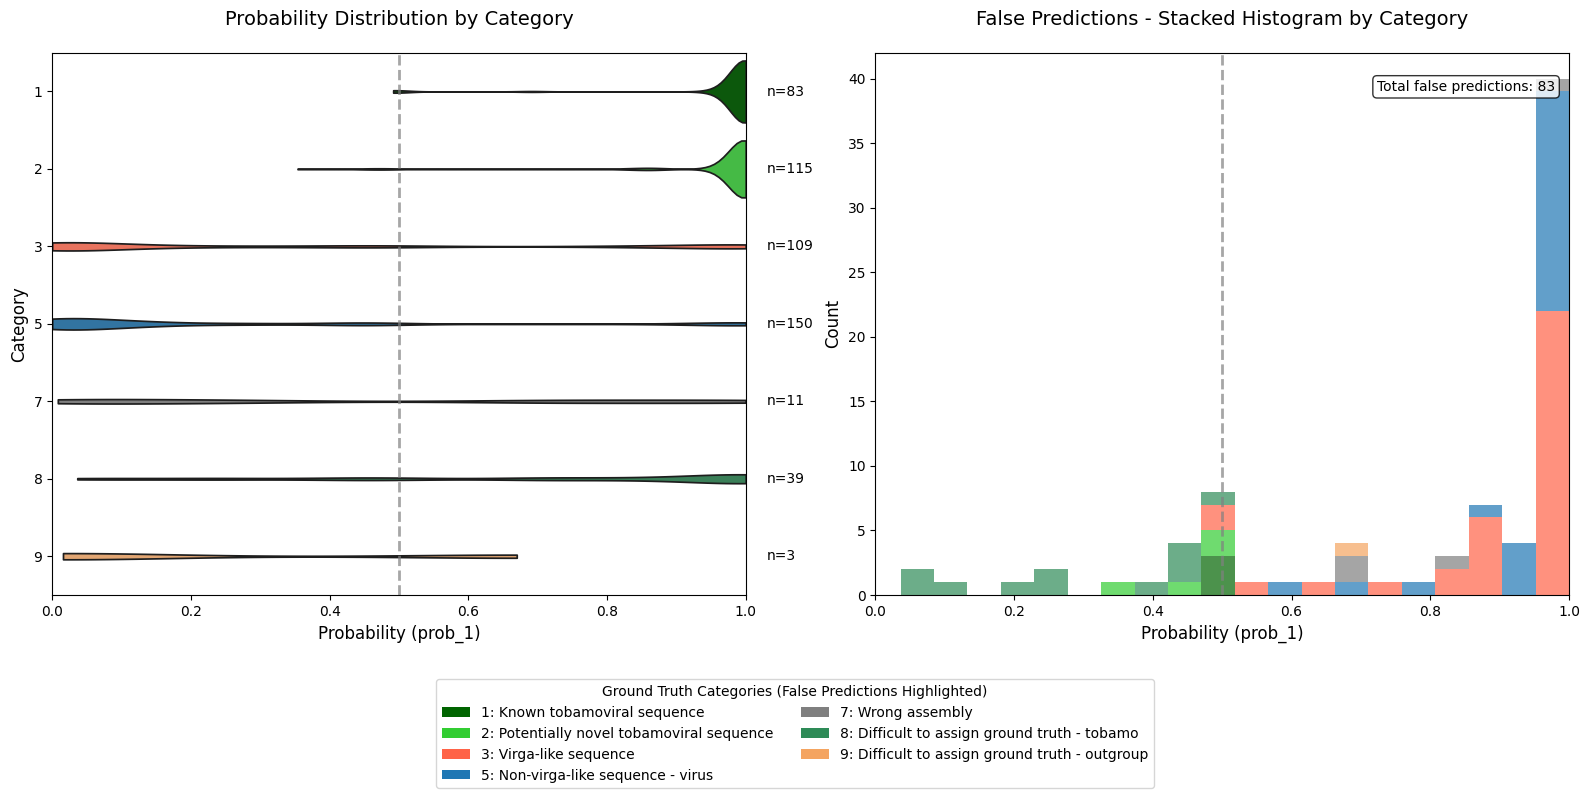

In [29]:
# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

df_filtered = merge.copy()
df_filtered['category'] = df_filtered['category'].astype(str)
df_filtered['prob_1'] = df_filtered['prob_1'].astype(float)
sorted_labels = sorted(df_filtered['category'].dropna().unique())

# Filter for false predictions only
false_predictions = df_filtered[df_filtered['ground_truth'] != df_filtered['predicted_class']]

# Define the category palette
category_palette = {
    '1': "#006400",   # dark green
    '2': "#32CD32",   # lime green
    '8': "#2E8B57",   # sea green
    '3': "#FF6347",   # tomato
    '4': "#FFA500",   # orange
    '9': "#F4A460",   # sandy brown
    '5': "#1f77b4",   # blue
    '6': "#6baed6",   # light blue
    '7': "#7f7f7f",   # grey
}

# Define category descriptions
category_map = {
    '1': "Known tobamoviral sequence",
    '2': "Potentially novel tobamoviral sequence",
    '3': "Virga-like sequence",
    '4': "Known virga-outgroup",
    '5': "Non-virga-like sequence - virus",
    '6': "Non-virga-like sequence - other",
    '7': "Wrong assembly",
    '8': "Difficult to assign ground truth - tobamo",
    '9': "Difficult to assign ground truth - outgroup"
}

# LEFT PLOT: Violin plot with x and y switched (all data)
sns.violinplot(data=df_filtered, y='category', x='prob_1', order=sorted_labels, 
              cut=0, hue='category', palette=category_palette, common_norm=True, 
              bw_adjust=0.5, legend=False, inner=None, ax=ax1)

# Formatting for violin plot
ax1.set_title('Probability Distribution by Category', fontsize=14, pad=20)
ax1.set_ylabel('Category', fontsize=12)
ax1.set_xlabel('Probability (prob_1)', fontsize=12)
ax1.set_xlim(0, 1)

# Add reference line at 0.5 (classification threshold) - vertical
ax1.axvline(x=0.5, color='gray', linestyle='--', alpha=0.7, linewidth=2)

# Set y-axis ticks without rotation
ax1.tick_params(axis='y', rotation=0)

# Add counts next to each category
for i, category in enumerate(sorted_labels):
    count = len(df_filtered[df_filtered['category'] == category])
    ax1.text(1.03, i, f'n={count}', va='center', fontsize=10)

# RIGHT PLOT: Stacked histogram for false predictions only
# Prepare data for stacked histogram
false_data_by_category = []
false_labels = []
false_colors = []

for category in sorted_labels:
    category_data = false_predictions[false_predictions['category'] == category]
    if len(category_data) > 0:
        false_data_by_category.append(category_data['prob_1'])
        false_labels.append(f'Category {category}')
        false_colors.append(category_palette[category])

# Create stacked histogram
if false_data_by_category:
    ax2.hist(false_data_by_category, bins=20, alpha=0.7, 
             color=false_colors, label=false_labels, stacked=True)

# Formatting for histogram
ax2.set_title('False Predictions - Stacked Histogram by Category', fontsize=14, pad=20)
ax2.set_xlabel('Probability (prob_1)', fontsize=12)
ax2.set_ylabel('Count', fontsize=12)
ax2.set_xlim(0, 1)

# Add reference line at 0.5 (classification threshold) - vertical
ax2.axvline(x=0.5, color='gray', linestyle='--', alpha=0.7, linewidth=2)

# Add text showing total false predictions
total_false = len(false_predictions)
ax2.text(0.98, 0.95, f'Total false predictions: {total_false}', 
         transform=ax2.transAxes, ha='right', va='top', 
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Create legend patches with category colors and descriptions
legend_handles = []
for cat in sorted(category_palette.keys()):
    if cat in false_predictions['category'].unique():
        patch = plt.Rectangle((0,0), 1, 1, fc=category_palette[cat])
        legend_handles.append((patch, f"{cat}: {category_map[cat]}"))

patches, labels = zip(*legend_handles)

# Add legend below the plots
fig.legend(
    patches, labels,
    loc='lower center',
    bbox_to_anchor=(0.5, 0),
    title="Ground Truth Categories (False Predictions Highlighted)",
    fontsize=10,
    ncol=2
)

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(bottom=0.25)
plt.show()

/tmp/ipykernel_1387711/2611557751.py:138: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


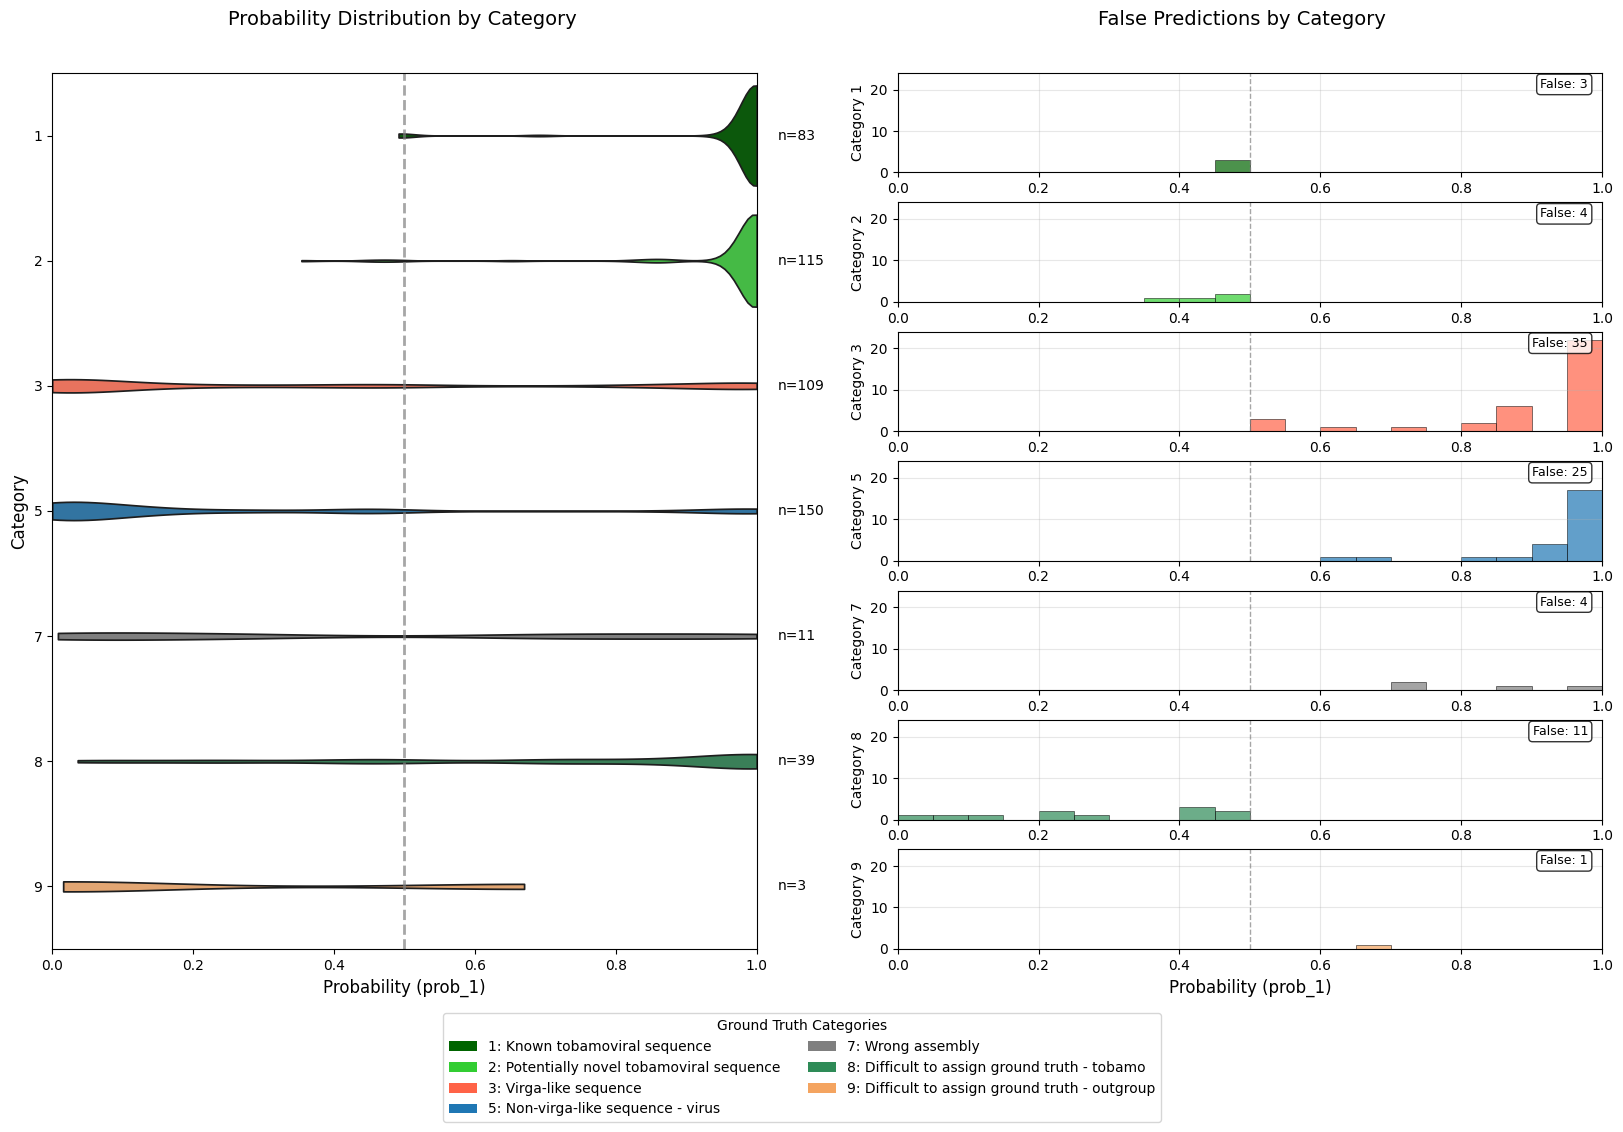

In [36]:
# Create a figure with multiple subplots - violin plot on left, separate histograms for each category on right
fig = plt.figure(figsize=(20, 12))

df_filtered = merge.copy()
df_filtered['category'] = df_filtered['category'].astype(str)
df_filtered['prob_1'] = df_filtered['prob_1'].astype(float)
sorted_labels = sorted(df_filtered['category'].dropna().unique())

# Filter for false predictions only
false_predictions = df_filtered[df_filtered['ground_truth'] != df_filtered['predicted_class']]

# Define the category palette
category_palette = {
    '1': "#006400",   # dark green
    '2': "#32CD32",   # lime green
    '8': "#2E8B57",   # sea green
    '3': "#FF6347",   # tomato
    '4': "#FFA500",   # orange
    '9': "#F4A460",   # sandy brown
    '5': "#1f77b4",   # blue
    '6': "#6baed6",   # light blue
    '7': "#7f7f7f",   # grey
}

# Define category descriptions
category_map = {
    '1': "Known tobamoviral sequence",
    '2': "Potentially novel tobamoviral sequence",
    '3': "Virga-like sequence",
    '4': "Known virga-outgroup",
    '5': "Non-virga-like sequence - virus",
    '6': "Non-virga-like sequence - other",
    '7': "Wrong assembly",
    '8': "Difficult to assign ground truth - tobamo",
    '9': "Difficult to assign ground truth - outgroup"
}

# Create grid layout: 1 column for violin plot, 7 rows for histograms
gs = fig.add_gridspec(len(sorted_labels), 2, width_ratios=[1, 1], hspace=0.3)

# LEFT PLOT: Violin plot with x and y switched (all data)
ax_violin = fig.add_subplot(gs[:, 0])
sns.violinplot(data=df_filtered, y='category', x='prob_1', order=sorted_labels, 
              cut=0, hue='category', palette=category_palette, common_norm=True, 
              bw_adjust=0.5, legend=False, inner=None, ax=ax_violin)

# Formatting for violin plot
ax_violin.set_ylabel('Category', fontsize=12)
ax_violin.set_xlabel('Probability (prob_1)', fontsize=12)
ax_violin.set_xlim(0, 1)

# Add reference line at 0.5 (classification threshold) - vertical
ax_violin.axvline(x=0.5, color='gray', linestyle='--', alpha=0.7, linewidth=2)

# Set y-axis ticks without rotation
ax_violin.tick_params(axis='y', rotation=0)

# Add counts next to each category
for i, category in enumerate(sorted_labels):
    count = len(df_filtered[df_filtered['category'] == category])
    ax_violin.text(1.03, i, f'n={count}', va='center', fontsize=10)

# RIGHT PLOTS: Individual histograms for each category (false predictions only)

bin_width = 0.05  # 5% probability width per bin
bins = np.arange(0, 1 + bin_width, bin_width)  # Creates bins from 0 to 1 with fixed width

# First, determine the maximum y-value across all histograms for shared y-axis
max_y = 0
for category in sorted_labels:
    category_false_data = false_predictions[false_predictions['category'] == category]
    if len(category_false_data) > 0:
        counts, _ = np.histogram(category_false_data['prob_1'], bins=15)
        max_y = max(max_y, counts.max())

# Add some padding to the max y value
max_y = int(max_y * 1.1) + 1

for i, category in enumerate(sorted_labels):
    ax_hist = fig.add_subplot(gs[i, 1])
    
    # Get false predictions for this category
    category_false_data = false_predictions[false_predictions['category'] == category]
    
    if len(category_false_data) > 0:
        ax_hist.hist(category_false_data['prob_1'], bins=bins, alpha=0.7, 
                     color=category_palette[category], edgecolor='black', linewidth=0.5)
        
        # Add count text
        false_count = len(category_false_data)
        ax_hist.text(0.98, 0.95, f'False: {false_count}', 
                     transform=ax_hist.transAxes, ha='right', va='top', 
                     bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
                     fontsize=9)
    else:
        # If no false predictions, show empty plot
        ax_hist.text(0.5, 0.5, 'No false\npredictions', 
                     transform=ax_hist.transAxes, ha='center', va='center',
                     fontsize=10, alpha=0.7)
    
    # Formatting for each histogram
    ax_hist.set_xlim(0, 1)
    ax_hist.set_ylim(0, max_y)  # Set shared y-axis limits
    ax_hist.axvline(x=0.5, color='gray', linestyle='--', alpha=0.7, linewidth=1)
    ax_hist.set_ylabel(f'Category {category}', fontsize=10)
    ax_hist.grid(True, alpha=0.3)
    
    # Only add x-label to bottom histogram
    if i == len(sorted_labels) - 1:
        ax_hist.set_xlabel('Probability (prob_1)', fontsize=12)
    else:
        ax_hist.set_xlabel('')

# Add aligned main titles for both sections
fig.text(0.3, 0.92, 'Probability Distribution by Category', fontsize=14, ha='center')
fig.text(0.72, 0.92, 'False Predictions by Category', fontsize=14, ha='center')

# Create legend patches with category colors and descriptions
legend_handles = []
for cat in sorted(category_palette.keys()):
    if cat in df_filtered['category'].unique():
        patch = plt.Rectangle((0,0), 1, 1, fc=category_palette[cat])
        legend_handles.append((patch, f"{cat}: {category_map[cat]}"))

patches, labels = zip(*legend_handles)

# Add legend below the plots
fig.legend(
    patches, labels,
    loc='lower center',
    bbox_to_anchor=(0.5, 0),
    title="Ground Truth Categories",
    fontsize=10,
    ncol=2
)

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(bottom=0.15)
plt.show()

/tmp/ipykernel_1964105/3399989885.py:163: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


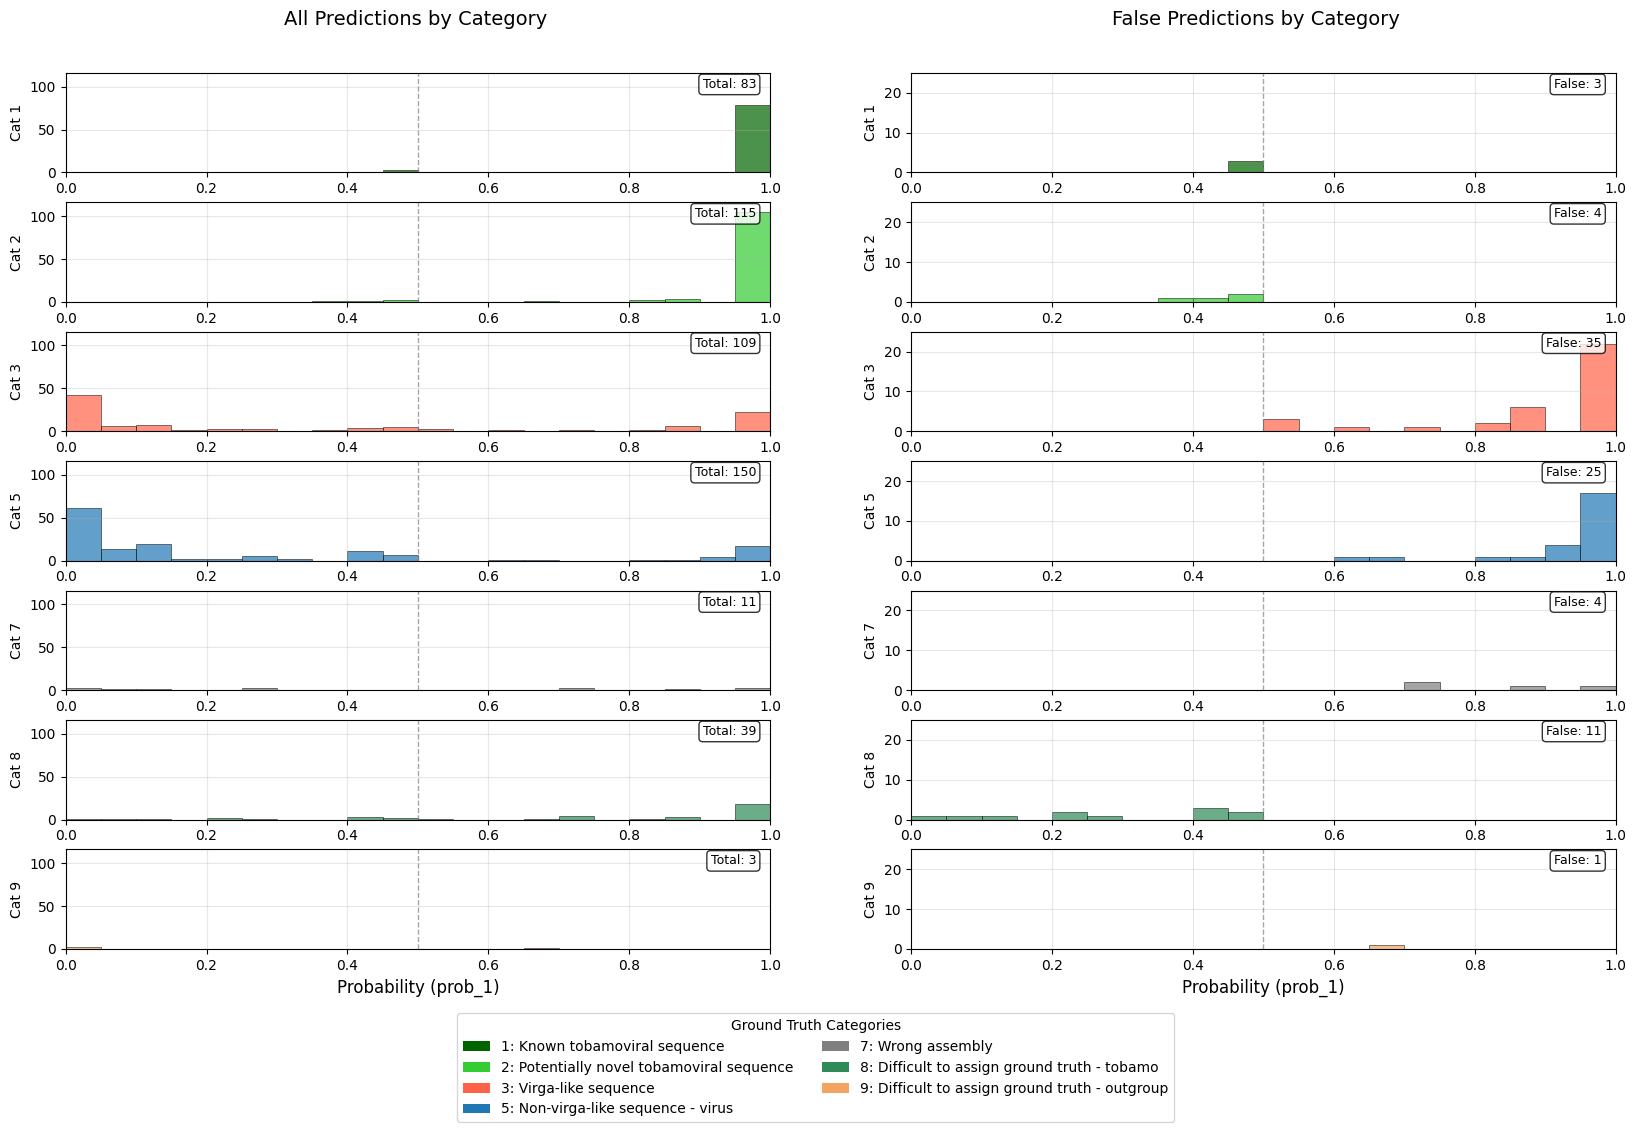

In [6]:
# Create a figure with multiple subplots - histograms on left, separate histograms for each category on right
fig = plt.figure(figsize=(20, 12))

df_filtered = merge.copy()
df_filtered['category'] = df_filtered['category'].astype(str)
df_filtered['prob_1'] = df_filtered['prob_1'].astype(float)
sorted_labels = sorted(df_filtered['category'].dropna().unique())

# Filter for false predictions only
false_predictions = df_filtered[df_filtered['ground_truth'] != df_filtered['predicted_class']]

# Define the category palette
category_palette = {
    '1': "#006400",   # dark green
    '2': "#32CD32",   # lime green
    '8': "#2E8B57",   # sea green
    '3': "#FF6347",   # tomato
    '4': "#FFA500",   # orange
    '9': "#F4A460",   # sandy brown
    '5': "#1f77b4",   # blue
    '6': "#6baed6",   # light blue
    '7': "#7f7f7f",   # grey
}

# Define category descriptions
category_map = {
    '1': "Known tobamoviral sequence",
    '2': "Potentially novel tobamoviral sequence",
    '3': "Virga-like sequence",
    '4': "Known virga-outgroup",
    '5': "Non-virga-like sequence - virus",
    '6': "Non-virga-like sequence - other",
    '7': "Wrong assembly",
    '8': "Difficult to assign ground truth - tobamo",
    '9': "Difficult to assign ground truth - outgroup"
}

# Create grid layout: 1 column for histograms, 7 rows for false prediction histograms
gs = fig.add_gridspec(len(sorted_labels), 2, width_ratios=[1, 1], hspace=0.3)

# Define bins for consistent bin width across all histograms
bin_width = 0.05  # 5% probability width per bin
bins = np.arange(0, 1 + bin_width, bin_width)  # Creates bins from 0 to 1 with fixed width

# LEFT PLOTS: Individual histograms for each category (all data)
# First, determine the maximum y-value across all left histograms for shared y-axis
max_y_left = 0
for category in sorted_labels:
    category_data = df_filtered[df_filtered['category'] == category]
    if len(category_data) > 0:
        counts, _ = np.histogram(category_data['prob_1'], bins=bins)
        max_y_left = max(max_y_left, counts.max())

# Add some padding to the max y value
max_y_left = int(max_y_left * 1.1) + 1

for i, category in enumerate(sorted_labels):
    ax_hist_left = fig.add_subplot(gs[i, 0])
    
    # Get all data for this category
    category_data = df_filtered[df_filtered['category'] == category]
    
    if len(category_data) > 0:
        ax_hist_left.hist(category_data['prob_1'], bins=bins, alpha=0.7, 
                         color=category_palette[category], edgecolor='black', linewidth=0.5)
        
        # Add count text
        total_count = len(category_data)
        ax_hist_left.text(0.98, 0.95, f'Total: {total_count}', 
                         transform=ax_hist_left.transAxes, ha='right', va='top', 
                         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
                         fontsize=9)
    else:
        # If no data, show empty plot
        ax_hist_left.text(0.5, 0.5, 'No data', 
                         transform=ax_hist_left.transAxes, ha='center', va='center',
                         fontsize=10, alpha=0.7)
    
    # Formatting for each left histogram
    ax_hist_left.set_xlim(0, 1)
    ax_hist_left.set_ylim(0, max_y_left)  # Set shared y-axis limits
    ax_hist_left.axvline(x=0.5, color='gray', linestyle='--', alpha=0.7, linewidth=1)
    ax_hist_left.set_ylabel(f'Cat {category}', fontsize=10)
    ax_hist_left.grid(True, alpha=0.3)
    
    # Only add x-label to bottom histogram
    if i == len(sorted_labels) - 1:
        ax_hist_left.set_xlabel('Probability (prob_1)', fontsize=12)
    else:
        ax_hist_left.set_xlabel('')

# RIGHT PLOTS: Individual histograms for each category (false predictions only)
# First, determine the maximum y-value across all right histograms for shared y-axis
max_y_right = 0
for category in sorted_labels:
    category_false_data = false_predictions[false_predictions['category'] == category]
    if len(category_false_data) > 0:
        counts, _ = np.histogram(category_false_data['prob_1'], bins=bins)
        max_y_right = max(max_y_right, counts.max())

# Add some padding to the max y value
max_y_right = int(max_y_right * 1.1) + 1

for i, category in enumerate(sorted_labels):
    ax_hist_right = fig.add_subplot(gs[i, 1])
    
    # Get false predictions for this category
    category_false_data = false_predictions[false_predictions['category'] == category]
    
    if len(category_false_data) > 0:
        ax_hist_right.hist(category_false_data['prob_1'], bins=bins, alpha=0.7, 
                          color=category_palette[category], edgecolor='black', linewidth=0.5)
        
        # Add count text
        false_count = len(category_false_data)
        ax_hist_right.text(0.98, 0.95, f'False: {false_count}', 
                          transform=ax_hist_right.transAxes, ha='right', va='top', 
                          bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
                          fontsize=9)
    else:
        # If no false predictions, show empty plot
        ax_hist_right.text(0.5, 0.5, 'No false\npredictions', 
                          transform=ax_hist_right.transAxes, ha='center', va='center',
                          fontsize=10, alpha=0.7)
    
    # Formatting for each right histogram
    ax_hist_right.set_xlim(0, 1)
    ax_hist_right.set_ylim(0, max_y_right)  # Set shared y-axis limits
    ax_hist_right.axvline(x=0.5, color='gray', linestyle='--', alpha=0.7, linewidth=1)
    ax_hist_right.set_ylabel(f'Cat {category}', fontsize=10)
    ax_hist_right.grid(True, alpha=0.3)
    
    # Only add x-label to bottom histogram
    if i == len(sorted_labels) - 1:
        ax_hist_right.set_xlabel('Probability (prob_1)', fontsize=12)
    else:
        ax_hist_right.set_xlabel('')

# Add aligned main titles for both sections
fig.text(0.3, 0.92, 'All Predictions by Category', fontsize=14, ha='center')
fig.text(0.72, 0.92, 'False Predictions by Category', fontsize=14, ha='center')

# Create legend patches with category colors and descriptions
legend_handles = []
for cat in sorted(category_palette.keys()):
    if cat in df_filtered['category'].unique():
        patch = plt.Rectangle((0,0), 1, 1, fc=category_palette[cat])
        legend_handles.append((patch, f"{cat}: {category_map[cat]}"))

patches, labels = zip(*legend_handles)

# Add legend below the plots
fig.legend(
    patches, labels,
    loc='lower center',
    bbox_to_anchor=(0.5, 0),
    title="Ground Truth Categories",
    fontsize=10,
    ncol=2
)

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(bottom=0.15)
plt.show()

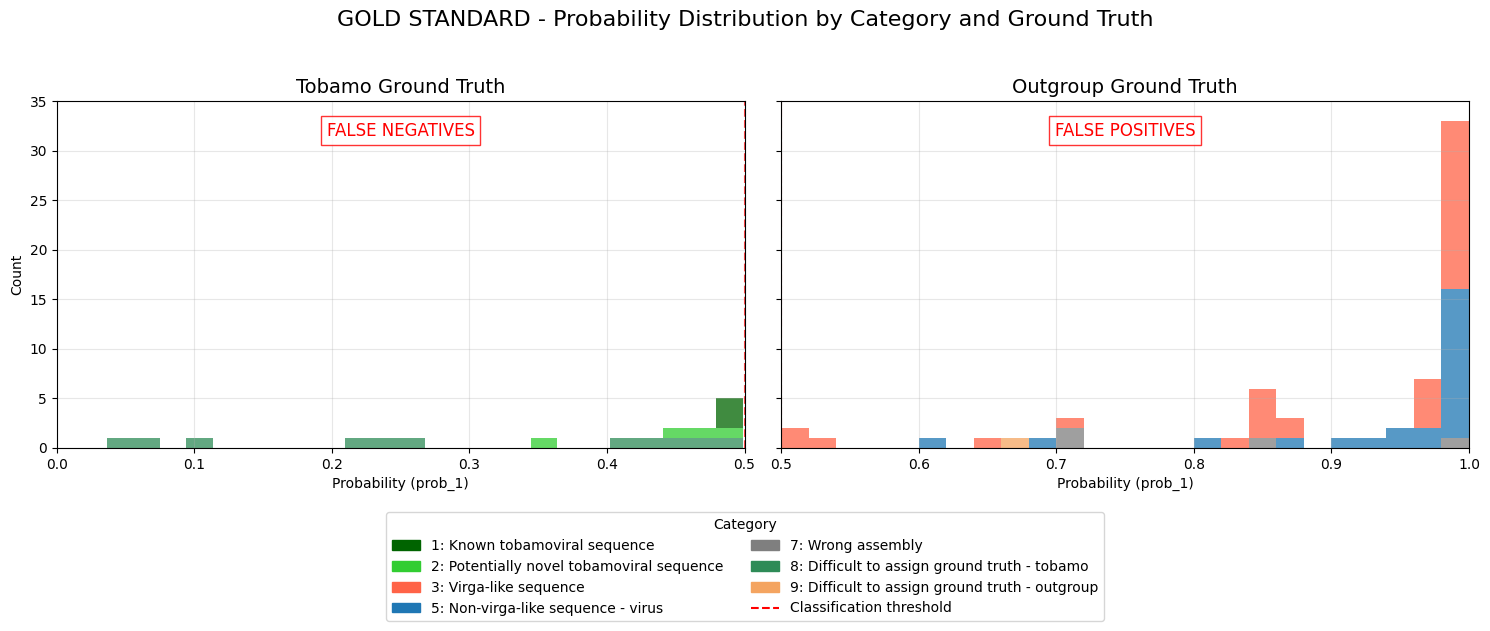

In [50]:
import matplotlib.patches as mpatches
import seaborn as sns
import matplotlib.pyplot as plt

# Map ground_truth values to labels
col_labels = {0.0: 'outgroup', 1.0: 'tobamo'}
merge['ground_truth_label'] = merge['ground_truth'].map(col_labels)

category_map = {
    1: "Known tobamoviral sequence",
    2: "Potentially novel tobamoviral sequence",
    3: "Virga-like sequence",
    4: "Known virga-outgroup",
    5: "Non-virga-like sequence - virus",
    6: "Non-virga-like sequence - other",
    7: "Wrong assembly",
    8: "Difficult to assign ground truth - tobamo",
    9: "Difficult to assign ground truth - outgroup"
}

category_palette = {
    1: "#006400",   # dark green
    2: "#32CD32",   # lime green
    8: "#2E8B57",   # sea green
    3: "#FF6347",   # tomato
    4: "#FFA500",   # orange
    9: "#F4A460",   # sandy brown
    5: "#1f77b4",   # blue
    6: "#6baed6",   # light blue
    7: "#7f7f7f",   # grey
}

# Create a figure with two subplots side by side (one for each ground truth label)
fig, axes = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

# Convert category to numeric type if it's not already
if merge['category'].dtype != 'int64':
    merge['category'] = merge['category'].astype(int)

# Prepare data for tobamo and outgroup
tobamo_data = merge[merge['ground_truth_label'] == 'tobamo']
outgroup_data = merge[merge['ground_truth_label'] == 'outgroup']

# Plot histograms for tobamo (ground truth = 1)
sns.histplot(
    data=tobamo_data,
    x="prob_1",
    hue="category",
    bins=50,
    multiple="stack",
    palette=category_palette,
    edgecolor=None,
    ax=axes[0]
)
axes[0].set_title('Tobamo Ground Truth', fontsize=14)
axes[0].set_xlabel("Probability (prob_1)")
axes[0].set_ylabel("Count")
axes[0].set_xlim(0, 0.5)
axes[0].set_xticks([0, 0.1, 0.2, 0.3, 0.4, 0.5])
axes[0].grid(alpha=0.3)
axes[0].set_ylim(0, 35)

# Plot histograms for outgroup (ground truth = 0)
sns.histplot(
    data=outgroup_data,
    x="prob_1",
    hue="category",
    bins=50,
    multiple="stack",
    palette=category_palette,
    edgecolor=None,
    ax=axes[1]
)
axes[1].set_title('Outgroup Ground Truth', fontsize=14)
axes[1].set_xlabel("Probability (prob_1)")
axes[1].set_xlim(0.5, 1)  # Focus on false positives
axes[1].set_xticks([0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
axes[1].grid(alpha=0.3)
axes[1].set_ylim(0, 35)

# Add classification threshold line
axes[0].axvline(x=0.5, color='red', linestyle='--', alpha=0.7, label='Classification threshold')
axes[1].axvline(x=0.5, color='red', linestyle='--', alpha=0.7)

# Remove legends from the histplots
axes[0].get_legend().remove()
axes[1].get_legend().remove()

# Add annotation for false predictions
axes[0].text(0.25, axes[0].get_ylim()[1]*0.9, "FALSE NEGATIVES", 
            ha='center', fontsize=12, color='red', 
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='red'))

axes[1].text(0.75, axes[1].get_ylim()[1]*0.9, "FALSE POSITIVES", 
            ha='center', fontsize=12, color='red', 
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='red'))

# Custom legend for categories with descriptive names
handles = [
    mpatches.Patch(color=category_palette[cat], label=f'{cat}: {category_map[cat]}')
    for cat in sorted(category_palette.keys())
    if cat in merge['category'].unique()  # Only include categories present in the data
]

# Add threshold line to legend
handles.append(plt.Line2D([0], [0], color='red', linestyle='--', label='Classification threshold'))

# Add a common legend for both plots
fig.legend(
    handles=handles,
    title="Category",
    loc='lower center',
    bbox_to_anchor=(0.5, 0),
    frameon=True,
    ncol=2,
    fontsize=10
)

plt.suptitle("GOLD STANDARD - Probability Distribution by Category and Ground Truth", y=1.03, fontsize=16)

# Adjust layout with space for the legend at the bottom
plt.tight_layout()
plt.subplots_adjust(bottom=0.3)

plt.show()

### RANDOM SEQUENCES

In [6]:
orf_random_predictions = pd.read_csv('/home/tobamo/analize/project-tobamo/analysis/model/results/random_seq/predictions/orf_predictions.csv', index_col=0)
contigs_random_predictions = pd.read_csv('/home/tobamo/analize/project-tobamo/analysis/model/results/random_seq/predictions/contig_predictions.csv', index_col=0)

In [10]:
len(orf_random_predictions), len(contigs_random_predictions)

(603, 41)

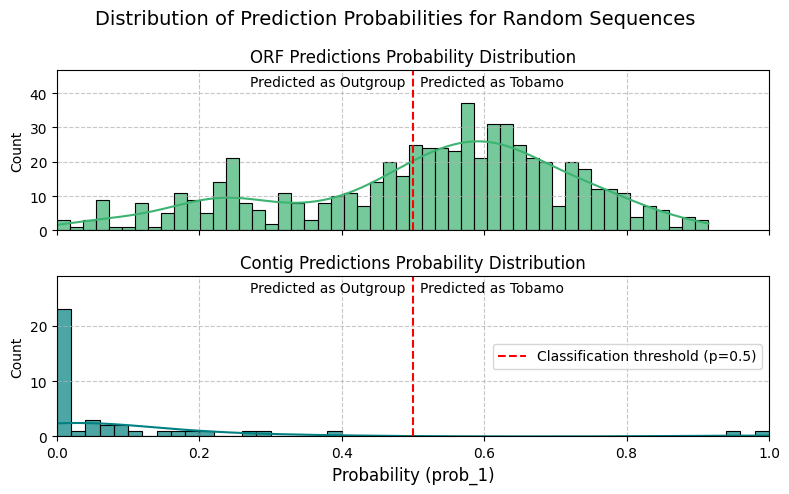

In [29]:
# Create a figure with 2 stacked subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 5), sharex=True)

# Plot histogram of ORF predictions (top subplot)
sns.histplot(data=orf_random_predictions, x="prob_1", bins=50, 
             kde=True, color="mediumseagreen", alpha=0.7, ax=ax1)

max_height = ax1.get_ylim()[1]
ax1.set_ylim(0, max_height * 1.2)

ax1.set_title('ORF Predictions Probability Distribution', fontsize=12)
ax1.set_ylabel('Count', fontsize=10)
ax1.grid(True, linestyle='--', alpha=0.7)
ax1.axvline(x=0.5, color='red', linestyle='--')
ax1.text(0.51, ax1.get_ylim()[1]*0.9, "Predicted as Tobamo", fontsize=10)
ax1.text(0.49, ax1.get_ylim()[1]*0.9, "Predicted as Outgroup", 
        fontsize=10, ha='right')

# Plot histogram of contig predictions (bottom subplot)
sns.histplot(data=contigs_random_predictions, x="prob_1", bins=50, 
             kde=True, color="teal", alpha=0.7, ax=ax2)

max_height = ax2.get_ylim()[1]
ax2.set_ylim(0, max_height * 1.2)

ax2.set_title('Contig Predictions Probability Distribution', fontsize=12)
ax2.set_xlabel('Probability (prob_1)', fontsize=12)
ax2.set_ylabel('Count', fontsize=10)
ax2.grid(True, linestyle='--', alpha=0.7)
ax2.axvline(x=0.5, color='red', linestyle='--', 
           label='Classification threshold (p=0.5)')
ax2.text(0.51, ax2.get_ylim()[1]*0.9, "Predicted as Tobamo", fontsize=10)
ax2.text(0.49, ax2.get_ylim()[1]*0.9, "Predicted as Outgroup", 
        fontsize=10, ha='right')
ax2.legend(loc = 'center right', fontsize=10)

# Set common x-axis limits
plt.xlim(0, 1)

# Add overall title
fig.suptitle('Distribution of Prediction Probabilities for Random Sequences', 
             fontsize=14, y=0.98)

# Adjust layout
plt.tight_layout()
plt.show()

In [11]:
random_seq_dict = {record.id: record.description for record in SeqIO.parse('/home/tobamo/analize/project-tobamo/analysis/data/random_seq/non-virga_tpdb2_diamond_selected.fasta', 'fasta')}

In [14]:
contigs_random_predictions['description'] = contigs_random_predictions.index.map(random_seq_dict)

In [15]:
contigs_random_predictions[contigs_random_predictions['predicted_class'] == 1]

,predicted_class,prob_1,description
contig_name,,,
NC_043417.1,1,0.999891,NC_043417.1 Olive leaf yellowing associated vi...
NC_078392.1,1,0.956216,NC_078392.1 Tomato blunervirus 1 isolate Fondi...


In [19]:
contigs_random_predictions[contigs_random_predictions['predicted_class'] == 0].sort_values(by='prob_1', ascending=False)

,predicted_class,prob_1,description
contig_name,,,
NC_075080.1,0,3.913786e-01,NC_075080.1 Euphorbia caput-medusae latent vir...
NC_040389.1,0,2.992810e-01,NC_040389.1 Sambucus virus S isolate B15 segme...
NC_076213.1,0,2.712528e-01,NC_076213.1 Tomato apical leaf curl virus isol...
NC_076569.1,0,2.188964e-01,NC_076569.1 Bat hepatitis E virus isolate Bat ...
NC_075086.1,0,1.873837e-01,"NC_075086.1 Wheat dwarf virus V1 gene, V2 gene..."
NC_001495.1,0,1.629684e-01,"NC_001495.1 Alfalfa mosaic virus RNA 1, comple..."
NC_075308.1,0,1.509267e-01,NC_075308.1 Spider associated circular virus 1...
NC_076020.1,0,1.065028e-01,NC_076020.1 Sesame yellow mosaic virus isolate...
NC_075307.1,0,9.371361e-02,NC_075307.1 Cybaeus spider associated circular...


In [2]:
histogram_cv = pd.read_csv('/home/tobamo/analize/project-tobamo/analysis/model/results/evaluation_results/histogram_predictions_results.csv')
orf_histogram_cv = pd.read_csv('/home/tobamo/analize/project-tobamo/analysis/model/results/evaluation_results/orf_predictions_results.csv')

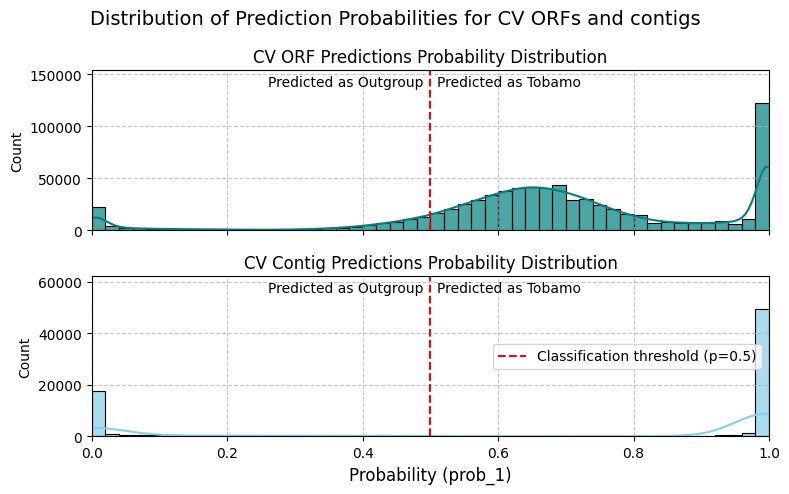

In [4]:
# Create a figure with 2 stacked subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 5), sharex=True)

# Plot histogram of ORF predictions (top subplot)
sns.histplot(data=orf_histogram_cv, x="prob_1", bins=50, 
             kde=True, color="teal", alpha=0.7, ax=ax1)

max_height = ax1.get_ylim()[1]
ax1.set_ylim(0, max_height * 1.2)

ax1.set_title('CV ORF Predictions Probability Distribution', fontsize=12)
ax1.set_ylabel('Count', fontsize=10)
ax1.grid(True, linestyle='--', alpha=0.7)
ax1.axvline(x=0.5, color='red', linestyle='--')
ax1.text(0.51, ax1.get_ylim()[1]*0.9, "Predicted as Tobamo", fontsize=10)
ax1.text(0.49, ax1.get_ylim()[1]*0.9, "Predicted as Outgroup", 
        fontsize=10, ha='right')

# Plot histogram of contig predictions (bottom subplot)
sns.histplot(data=histogram_cv, x="prob_1", bins=50, 
             kde=True, color="skyblue", alpha=0.7, ax=ax2)

max_height = ax2.get_ylim()[1]
ax2.set_ylim(0, max_height * 1.2)

ax2.set_title('CV Contig Predictions Probability Distribution', fontsize=12)
ax2.set_xlabel('Probability (prob_1)', fontsize=12)
ax2.set_ylabel('Count', fontsize=10)
ax2.grid(True, linestyle='--', alpha=0.7)
ax2.axvline(x=0.5, color='red', linestyle='--', 
           label='Classification threshold (p=0.5)')
ax2.text(0.51, ax2.get_ylim()[1]*0.9, "Predicted as Tobamo", fontsize=10)
ax2.text(0.49, ax2.get_ylim()[1]*0.9, "Predicted as Outgroup", 
        fontsize=10, ha='right')
ax2.legend(loc = 'center right', fontsize=10)

# Set common x-axis limits
plt.xlim(0, 1)

# Add overall title
fig.suptitle('Distribution of Prediction Probabilities for CV ORFs and contigs', 
             fontsize=14, y=0.98)

# Adjust layout
plt.tight_layout()
plt.show()